# GTHA housing market database
# OSEMN methodology Step 2: Scrub
# Step 2.2 Correction of inconsistent entries in the Teranet dataset

---

This notebook describes Step 2.2 (part of _Step 2: Scrub_ of OSEMN methodology) performed on the Teranet dataset.

Step 2.2 focuses on the correction of inconsistent entries in the Teranet dataset. Cleanup plan is presented below.

Previous steps included: 

* Step 2.1 

    * the spatial join between the Teranet points and the polygons of GTHA Dissemination Areas (DAs)
    
    * During step 2.1, Teranet records whose coordinates fall outside of the GTHA boundary (as defined by the DA geometry) have been filtered out (6,803,691 of the original 9,039,241 Teranet records remain in the dataset)
     
    * In addition to that, three new columns (`OBJECTID`, `DAUID`, and `CSDNAME`) derived from DA attributes have been added to each Teranet transaction

---

For description of OSEMN methodology, see `methodology/0.osemn/osemn.pdf`.

For background information, description of the Teranet dataset, and its attributes, see `methodology/1.obtain/obtain.pdf`.

For description of _Step 2: Scrub_ of OSEMN methodology, see `methodology/2.scrub/scrub.pdf`.

For description of the cleanup plan for the Teranet dataset, see `methodology/2.scrub/teranet_cleanup_plan.pdf`.

For description of Step 2.1 of the cleanup process, see `notebooks/2.scrub/2.1_teranet_gtha_spatial_join.ipynb`.

## Cleanup plan

1. Convert column names to lower case
2. Fix inconsistent capitalizations for values in columns:
    * `municipality`
    * `street_name`
    * `street_designation`
    * `postal_code` (do not show problems, preventive measure)
3. Remove column `province`
4. Create a reserve copy of unmodified column `street_name` -- `street_name_raw`
5. Remove municipality mentions from `street_name`
6. Parse `postal_code` from `street_name`
7. Validate consistency of values in column `postal_code`
8. Parse `unitno` from `street_name`
9. Parse `street_number` from `street_name`
10. Parse `street_direction` from `street_name`
11. Parse `street_designation` from `street_name`
12. Investigate missing values
13. Remove column `street_suffix`
14. Fix inconsistent entries in columns:
    * 14.1: `street_direction`
    * 14.2: `street_designation`
    * 14.3: `municipality`
    * 14.4: `street_name`
    * 14.5: `unitno`
    
## Import dependencies

In [7]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
from time import time

sns.set()

In [8]:
data_path = '../../data/teranet/'
os.listdir(data_path)

['Teranet_with_DA_cols.csv', 'HHSaleHistory.csv']

## Load Teranet data

In [9]:
t = time()
df = pd.read_csv(data_path + 'Teranet_with_DA_cols.csv',
                 parse_dates=['registration_date'], low_memory=False)
#df = pd.read_csv(data_path + 'Teranet_with_DA_cols.csv') # parsing dates takes ~10 minutes
elapsed = time() - t
print("----- DataFrame loaded"
      "\nin {0:,.2f} seconds ({1:.2f} minutes)".format(elapsed, elapsed / 60) + 
      "\nwith {0:,} rows\nand {1:,} columns"
      .format(df.shape[0], df.shape[1]) + 
      "\n-- Column names:\n", df.columns)

----- DataFrame loaded
in 1,288.33 seconds (21.47 minutes)
with 6,803,691 rows
and 18 columns
-- Column names:
 Index(['lro_num', 'pin', 'consideration_amt', 'registration_date',
       'POSTAL_CODE', 'PROVINCE', 'UNITNO', 'STREET_NAME',
       'STREET_DESIGNATION', 'STREET_DIRECTION', 'MUNICIPALITY',
       'STREET_SUFFIX', 'STREET_NUMBER', 'X', 'Y', 'OBJECTID', 'DAUID',
       'CSDNAME'],
      dtype='object')


## Step 1: convert column names to lower case

In [10]:
df.columns = df.columns.str.lower()
df.columns

Index(['lro_num', 'pin', 'consideration_amt', 'registration_date',
       'postal_code', 'province', 'unitno', 'street_name',
       'street_designation', 'street_direction', 'municipality',
       'street_suffix', 'street_number', 'x', 'y', 'objectid', 'dauid',
       'csdname'],
      dtype='object')

## Step 2: fix inconsistent capitalizations
Inconsistent capitalizations are fixed for values in the following columns: 
* `unitno`
* `street_name`
* `street_designaction`
* `street_direction`
* `municipality`

In [11]:
t = time()
df['municipality'] = df['municipality'].str.title()
df['street_name'] = df['street_name'].str.title()
df['street_designation'] = df['street_designation'].str.capitalize()
df['postal_code'] = df['postal_code'].str.upper()
elapsed = time() - t
print("Capitalizations were fixed! Took {0:,.2f} seconds.".format(elapsed))

Capitalizations were fixed! Took 10.84 seconds.


## Step 3: Remove column `province`

In [12]:
df = df.drop('province', axis=1)
print("Column 'province' was removed from the dataset.")

Column 'province' was removed from the dataset.


## Step 4: Create a reserve copy of unmodified column `street_name` -- `street_name_raw`

In [13]:
df['street_name_raw'] = df['street_name'].values
print("Column `street_name_raw` was created!")

Column `street_name_raw` was created!


## Step 5: Remove municipality mentions from `street_name`

#### Erase ', Mississaug' from the end of 'street_name'

In [14]:
mask1 = df['street_name'].str.contains(',\sMississaug', na=False, case=False)
df.loc[mask1, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
6131528,NaN,"130-5260 Mcfarren Blvd, Mississaug",NaN,Mississauga
6131815,NaN,"130-5260 Mcfarren Blvd, Mississaug",NaN,Mississauga
6132086,NaN,"130-5260 Mcfarren Blvd, Mississaug",NaN,Mississauga


In [15]:
df.loc[mask1, 'street_name'] = df.loc[mask1, 'street_name'].str.replace(', Mississaug', '')
df.loc[mask1, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
6131528,NaN,130-5260 Mcfarren Blvd,NaN,Mississauga
6131815,NaN,130-5260 Mcfarren Blvd,NaN,Mississauga
6132086,NaN,130-5260 Mcfarren Blvd,NaN,Mississauga


#### Erase ', Vaugh' from the end of 'street_name'

In [16]:
mask1 = df['street_name'].str.contains(',\sVaugh', na=False, case=False)
df.loc[mask1, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
4934561,NaN,"Highway 7 West, Vaughan On L4K 0H8",NaN,Richmond Hill
5042002,NaN,"Mactier Drive, Vaughan,",NaN,Vaughan
5042874,NaN,"Mactier Drive, Vaughan,",NaN,Vaughan
6387953,NaN,"510 Vellore Woods Boulevard, Vaugh",NaN,Vaughan


In [17]:
df.loc[mask1, 'street_name'] = \
    df.loc[mask1, 'street_name']\
    .str.replace(', Vaughan,', '')\
    .str.replace(', Vaughan On', '')\
    .str.replace(', Vaugh', '')
df.loc[mask1, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
4934561,NaN,Highway 7 West L4K 0H8,NaN,Richmond Hill
5042002,NaN,Mactier Drive,NaN,Vaughan
5042874,NaN,Mactier Drive,NaN,Vaughan
6387953,NaN,510 Vellore Woods Boulevard,NaN,Vaughan


## Step 6: Parse `postal_code` from `street_name`
Some Teranet records with missing `postal_code` have it as part of their `street_name` value.

In [18]:
mask1 = df['street_name'].str.contains('[A-Z]\d[A-Z]\d[A-Z]\d', na=False, case=False)
df.loc[mask1, ['street_name', 'street_designation', 'postal_code', 'municipality']]

,street_name,street_designation,postal_code,municipality
112676,Stoutt Crescent L9T9A2,Cres,L9T9A2,Milton
112945,Stoutt Crescent L9T9A2,Cres,L9T9A2,Milton
427026,Dundas St E L0R2H1,NaN,NaN,Waterdown
428281,Dundas St E L0R2H1,NaN,NaN,Waterdown
738425,Orton Pk Road M1G3H2,NaN,NaN,Toronto
738513,Orton Pk Road M1G3H2,NaN,NaN,Toronto
960503,Vines Place L4G0R6,NaN,NaN,Aurora
996169,Thorncliffe Pk Drive M4H1P3,NaN,NaN,East York
996320,Thorncliffe Pk Drive M4H1P3,NaN,NaN,East York
996405,Overlea Boulevard M4H1P2,NaN,NaN,Toronto


### Extract `postal_code` from `street_name`
#### Postal code entered with no space

In [19]:
df.loc[mask1, 'postal_code'] = \
    df.loc[mask1, 'street_name'].str.split().apply(lambda x: x[-1])
df.loc[mask1, 'street_name'] = \
    df.loc[mask1, 'street_name'].str.rsplit(' ', 1).apply(lambda x: x[0]).str.strip()
df.loc[mask1, ['street_name', 'street_designation', 'postal_code', 'municipality']]

,street_name,street_designation,postal_code,municipality
112676,Stoutt Crescent,Cres,L9T9A2,Milton
112945,Stoutt Crescent,Cres,L9T9A2,Milton
427026,Dundas St E,NaN,L0R2H1,Waterdown
428281,Dundas St E,NaN,L0R2H1,Waterdown
738425,Orton Pk Road,NaN,M1G3H2,Toronto
738513,Orton Pk Road,NaN,M1G3H2,Toronto
960503,Vines Place,NaN,L4G0R6,Aurora
996169,Thorncliffe Pk Drive,NaN,M4H1P3,East York
996320,Thorncliffe Pk Drive,NaN,M4H1P3,East York
996405,Overlea Boulevard,NaN,M4H1P2,Toronto


#### Postal code entered with a space

In [20]:
mask1 = df['street_name'].str.contains('[A-Z]\d[A-Z]\s\d[A-Z]\d', na=False, case=False)
df.loc[mask1, ['street_name', 'street_designation', 'postal_code', 'municipality']]

,street_name,street_designation,postal_code,municipality
55851,Steeles Ave W L0P 1B0,NaN,NaN,Milton
56294,Steeles Ave W L0P 1B0,NaN,NaN,Milton
56415,Steeles Ave W L0P 1B0,NaN,NaN,Milton
390471,First St L0B 1B0,NaN,NaN,Scugog
391093,First St L0B 1B0,NaN,NaN,Scugog
504933,The East Mall Street M9B 6C4,NaN,NaN,Etobicoke
505913,The East Mall Street M9B 6C4,NaN,NaN,Etobicoke
555427,Lakeshore Rd L0E 1N0,NaN,NaN,Pine Grove
555937,Lakeshore Rd L0E 1N0,NaN,NaN,Pine Grove
807098,Beach Rd L4P 2L6,NaN,NaN,Keswick


In [21]:
df.loc[mask1, 'postal_code'] = \
    df.loc[mask1, 'street_name'].str.rsplit(' ', 2)\
    .apply(lambda x: x[-2:]).apply(lambda x: ''.join(x)).str.strip()
df.loc[mask1, 'street_name'] = \
    df.loc[mask1, 'street_name'].str.rsplit(' ', 2).apply(lambda x: x[0]).str.strip()
df.loc[mask1, ['street_name', 'street_designation', 'postal_code', 'municipality']]

,street_name,street_designation,postal_code,municipality
55851,Steeles Ave W,NaN,L0P1B0,Milton
56294,Steeles Ave W,NaN,L0P1B0,Milton
56415,Steeles Ave W,NaN,L0P1B0,Milton
390471,First St,NaN,L0B1B0,Scugog
391093,First St,NaN,L0B1B0,Scugog
504933,The East Mall Street,NaN,M9B6C4,Etobicoke
505913,The East Mall Street,NaN,M9B6C4,Etobicoke
555427,Lakeshore Rd,NaN,L0E1N0,Pine Grove
555937,Lakeshore Rd,NaN,L0E1N0,Pine Grove
807098,Beach Rd,NaN,L4P2L6,Keswick


## Step 7: validate consistency of values in column `postal_code`
Column `postal_code` has been validated to contain the correct data format (Canadian postal codes).

570'609 values are missing, the rest follow the correct data format.

In [22]:
df['postal_code'].str.match('^[A-Z]\d[A-Z]\d[A-Z]\d$')\
    .value_counts(dropna=False)

True    6233365
NaN      570326
Name: postal_code, dtype: int64

## Step 8: Parse `unitno` from `street_name`
Some Teranet records with missing `unitno` have it as part of their `street_name` value.

In [23]:
mask1 = df['street_name'].str.contains('Unit', na=False, case=False)
mask2 = df['street_name'].str.contains('(Unity|Unita|United|Munition)', na=False, case=False)
df.loc[mask1 & ~mask2, ['unitno', 'street_name', 'street_designation', 'municipality']]

/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  


,unitno,street_name,street_designation,municipality
36607,NaN,"Speers Road, Unit 2006",NaN,Oakville
36609,NaN,"Speers Road, Unit 2006",NaN,Oakville
36610,NaN,"Speers Road, Unit 2006",NaN,Oakville
37024,NaN,"Speers Road, Unit 2006",NaN,Oakville
37026,NaN,"Speers Road, Unit 2006",NaN,Oakville
37027,NaN,"Speers Road, Unit 2006",NaN,Oakville
72967,NaN,"Preserve Drive, Unit 4",Dr,Oakville
72990,NaN,"Preserve Drive, Unit 13",Dr,Oakville
73064,NaN,"Sarah Cline Drive, Unit 4",Dr,Oakville
73068,NaN,"Ellen Davidson Drive, Unit 5",Dr,Oakville


### Extract `unitno` from `street_name`
#### Split by ','

In [24]:
mask1 = df['street_name'].str.contains('Unit', na=False, case=False)
mask2 = df['street_name'].str.contains('(Unity|Unita|United|Munition)', na=False, case=False)
mask3 = df['street_name'].str.contains(',')
df.loc[mask1 & ~mask2 & mask3, ['unitno', 'street_name', 'street_designation', 'municipality']]

/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  


,unitno,street_name,street_designation,municipality
36607,NaN,"Speers Road, Unit 2006",NaN,Oakville
36609,NaN,"Speers Road, Unit 2006",NaN,Oakville
36610,NaN,"Speers Road, Unit 2006",NaN,Oakville
37024,NaN,"Speers Road, Unit 2006",NaN,Oakville
37026,NaN,"Speers Road, Unit 2006",NaN,Oakville
37027,NaN,"Speers Road, Unit 2006",NaN,Oakville
72967,NaN,"Preserve Drive, Unit 4",Dr,Oakville
72990,NaN,"Preserve Drive, Unit 13",Dr,Oakville
73064,NaN,"Sarah Cline Drive, Unit 4",Dr,Oakville
73068,NaN,"Ellen Davidson Drive, Unit 5",Dr,Oakville


In [25]:
df.loc[mask1 & ~mask2 & mask3, 'unitno'] = \
    df.loc[mask1 & ~mask2 & mask3, 'street_name']\
    .str.split(',').apply(lambda x: x[-1]).str.replace('Unit', '').str.strip()
df.loc[mask1 & ~mask2 & mask3, 'street_name'] = \
    df.loc[mask1 & ~mask2 & mask3, 'street_name'].str.split(',')\
    .apply(lambda x: x[0]).str.strip()
df.loc[mask1 & ~mask2 & mask3, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
36607,2006,Speers Road,NaN,Oakville
36609,2006,Speers Road,NaN,Oakville
36610,2006,Speers Road,NaN,Oakville
37024,2006,Speers Road,NaN,Oakville
37026,2006,Speers Road,NaN,Oakville
37027,2006,Speers Road,NaN,Oakville
72967,4,Preserve Drive,Dr,Oakville
72990,13,Preserve Drive,Dr,Oakville
73064,4,Sarah Cline Drive,Dr,Oakville
73068,5,Ellen Davidson Drive,Dr,Oakville


### Extract `unitno` from `street_name`
#### Split by '-'

In [26]:
mask1 = df['street_name'].str.contains('Unit', na=False, case=False)
mask2 = df['street_name'].str.contains('(Unity|Unita|United|Munition)', na=False, case=False)
mask3 = df['street_name'].str.contains('-')
df.loc[mask1 & ~mask2 & mask3, ['unitno', 'street_name', 'street_designation', 'municipality']]

/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  


,unitno,street_name,street_designation,municipality
931018,NaN,George Street - Parking Unit,St,Toronto
931757,NaN,George Street - Parking Unit,St,Toronto
933483,NaN,George Street - Parking Unit,St,Toronto
935165,NaN,George Street - Parking Unit,St,Toronto
935841,NaN,George Street - Parking Unit,St,Toronto
1561933,NaN,St. Joseph Street-Locker Unit,NaN,Toronto
1561934,NaN,St. Joseph Street-Locker Unit,NaN,Toronto
1561935,NaN,St. Joseph Street-Locker Unit,NaN,Toronto
1561936,NaN,St. Joseph Street-Locker Unit,NaN,Toronto
2146741,NaN,Bathurst Street-Storage Unit,NaN,Toronto


In [27]:
df.loc[mask1 & ~mask2 & mask3, 'unitno'] = \
    df.loc[mask1 & ~mask2 & mask3, 'street_name']\
    .str.split('-').apply(lambda x: x[-1])\
    .str.replace('Unit', '')\
    .str.replace('10', 'H-10').str.strip()
df.loc[mask1 & ~mask2 & mask3, 'street_name'] = \
    df.loc[mask1 & ~mask2 & mask3, 'street_name']\
    .str.split('-').apply(lambda x: x[0])\
    .str.replace('Unit H', '').str.strip()
df.loc[mask1 & ~mask2 & mask3, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
931018,Parking,George Street,St,Toronto
931757,Parking,George Street,St,Toronto
933483,Parking,George Street,St,Toronto
935165,Parking,George Street,St,Toronto
935841,Parking,George Street,St,Toronto
1561933,Locker,St. Joseph Street,NaN,Toronto
1561934,Locker,St. Joseph Street,NaN,Toronto
1561935,Locker,St. Joseph Street,NaN,Toronto
1561936,Locker,St. Joseph Street,NaN,Toronto
2146741,Storage,Bathurst Street,NaN,Toronto


### Extract `unitno` from `street_name`
#### Split by '.'

In [28]:
mask1 = df['street_name'].str.contains('Unit', na=False, case=False)
mask2 = df['street_name'].str.contains('(Unity|Unita|United|Munition|St\.\sClair)', na=False, case=False)
mask3 = df['street_name'].str.contains('\.')
df.loc[mask1 & ~mask2 & mask3, ['unitno', 'street_name', 'street_designation', 'municipality']]

/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  


,unitno,street_name,street_designation,municipality
195536,NaN,Fairview St. Unit 77,St,Burlington
195537,NaN,Fairview St. Unit 77,St,Burlington
195538,NaN,Fairview St. Unit 77,St,Burlington
195652,NaN,Fairview St. Unit 77,St,Burlington
195653,NaN,Fairview St. Unit 77,St,Burlington
195654,NaN,Fairview St. Unit 77,St,Burlington
195961,NaN,Fairview St. Unit 77,St,Burlington
196053,NaN,Fairview St. Unit 77,St,Burlington
196259,NaN,Fairview St. Unit 77,St,Burlington
196260,NaN,Fairview St. Unit 77,St,Burlington


In [29]:
df.loc[mask1 & ~mask2 & mask3, 'unitno'] = \
    df.loc[mask1 & ~mask2 & mask3, 'street_name']\
    .str.split('.').apply(lambda x: x[-1])\
    .str.replace('Unit', '').str.strip()
df.loc[mask1 & ~mask2 & mask3, 'street_name'] = \
    df.loc[mask1 & ~mask2 & mask3, 'street_name']\
    .str.split('.').apply(lambda x: x[0]).str.strip()
df.loc[mask1 & ~mask2 & mask3, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
195536,77,Fairview St,St,Burlington
195537,77,Fairview St,St,Burlington
195538,77,Fairview St,St,Burlington
195652,77,Fairview St,St,Burlington
195653,77,Fairview St,St,Burlington
195654,77,Fairview St,St,Burlington
195961,77,Fairview St,St,Burlington
196053,77,Fairview St,St,Burlington
196259,77,Fairview St,St,Burlington
196260,77,Fairview St,St,Burlington


### Extract `unitno` from `street_name`
#### Specified in (brackets)

In [30]:
mask1 = df['street_name'].str.contains('Unit', na=False, case=False)
mask2 = df['street_name'].str.contains('(Unity|Unita|United|Munition)', na=False, case=False)
mask3 = df['street_name'].str.contains('\(')
df.loc[mask1 & ~mask2 & mask3, ['unitno', 'street_name', 'street_designation', 'municipality']]

/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  


,unitno,street_name,street_designation,municipality
1004919,NaN,Yonge Street (Parking Unit),NaN,Aurora
2091131,NaN,Peter Street (Storage Unit),NaN,Toronto
2225579,NaN,Robinson Street (Dwelling Unit),NaN,Hamilton
3274178,NaN,Shuter Street (Storage Unit),NaN,Toronto
3555248,NaN,Abell Street (Parking Unit),NaN,Toronto
3836427,NaN,York Street (Parking Unit),St,Toronto
3839871,NaN,York Street (Parking Unit),St,Toronto
5035302,NaN,Powseland Crescent (Parking Unit),NaN,Vaughan
5035607,NaN,Powseland Crescent (Parking Unit),NaN,Vaughan
5035859,NaN,Powseland Crescent (Parking Unit),NaN,Vaughan


In [31]:
df.loc[mask1 & ~mask2 & mask3, 'unitno'] = \
    df.loc[mask1 & ~mask2 & mask3, 'street_name']\
    .str.split('(').apply(lambda x: x[-1]).str.replace(')', '')\
    .str.replace('Unit', '').str.strip()
df.loc[mask1 & ~mask2 & mask3, 'street_name'] = \
    df.loc[mask1 & ~mask2 & mask3, 'street_name'].str.split('(')\
    .apply(lambda x: x[0]).str.strip()
df.loc[mask1 & ~mask2 & mask3, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
1004919,Parking,Yonge Street,NaN,Aurora
2091131,Storage,Peter Street,NaN,Toronto
2225579,Dwelling,Robinson Street,NaN,Hamilton
3274178,Storage,Shuter Street,NaN,Toronto
3555248,Parking,Abell Street,NaN,Toronto
3836427,Parking,York Street,St,Toronto
3839871,Parking,York Street,St,Toronto
5035302,Parking,Powseland Crescent,NaN,Vaughan
5035607,Parking,Powseland Crescent,NaN,Vaughan
5035859,Parking,Powseland Crescent,NaN,Vaughan


### Extract `unitno` from `street_name`
#### Specified at the end of the string

In [32]:
mask1 = df['street_name'].str.contains('Unit', na=False, case=False)
mask2 = df['street_name'].str.contains('(Unity|Unita|United|Munition)', na=False, case=False)
df.loc[mask1 & ~mask2, ['unitno', 'street_name', 'street_designation', 'municipality']]

/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  


,unitno,street_name,street_designation,municipality
911375,6,Nantucket Blvd Units 5,NaN,Toronto
911376,6,Nantucket Blvd Units 5,NaN,Toronto
2068778,NaN,Victoria Park Avenue Unit 1808,NaN,Toronto
2069011,NaN,Victoria Park Avenue Unit 1808,NaN,Toronto
2069392,NaN,Victoria Park Avenue Unit 1808,NaN,Toronto
2577606,NaN,Upper Wentworth Street Unit 21,NaN,Hamilton
2578003,NaN,Upper Wentworth Street Unit 21,NaN,Hamilton
2578004,NaN,Upper Wentworth Unit 13,NaN,Hamilton
2578207,NaN,Upper Wentworth Unit 13,NaN,Hamilton
2578264,NaN,Upper Wentworth Street Unit 21,NaN,Hamilton


In [33]:
df.loc[mask1 & ~mask2, 'unitno'] = \
    df.loc[mask1 & ~mask2, 'street_name']\
        .str.rsplit(' ', 2).apply(lambda x: x[-2:])\
        .apply(lambda x: ' '.join(x))\
        .str.replace('Unit', '')\
        .str.replace('s', 'Units')\
        .str.strip()
df.loc[mask1 & ~mask2, 'street_name'] = \
    df.loc[mask1 & ~mask2, 'street_name']\
        .str.rsplit(' ', 2).apply(lambda x: x[0]).str.strip()
df.loc[mask1 & ~mask2, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
911375,Units 5,Nantucket Blvd,NaN,Toronto
911376,Units 5,Nantucket Blvd,NaN,Toronto
2068778,1808,Victoria Park Avenue,NaN,Toronto
2069011,1808,Victoria Park Avenue,NaN,Toronto
2069392,1808,Victoria Park Avenue,NaN,Toronto
2577606,21,Upper Wentworth Street,NaN,Hamilton
2578003,21,Upper Wentworth Street,NaN,Hamilton
2578004,13,Upper Wentworth,NaN,Hamilton
2578207,13,Upper Wentworth,NaN,Hamilton
2578264,21,Upper Wentworth Street,NaN,Hamilton


### Extract `unitno` from `street_name`
#### Specified as 'Suite'

In [34]:
mask1 = df['street_name'].str.contains('Suite', na=False, case=False)
df.loc[mask1, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
764907,NaN,"Charles Street East, Suite 1903",NaN,Toronto
764911,NaN,"Charles Street East, Suite 2906",NaN,Toronto
764937,NaN,"Charles Street East, Suite 1709",NaN,Toronto
764964,NaN,"Charles Street East, Suite 1705",NaN,Toronto
764998,NaN,"Charles Street East, Suite 602",NaN,Toronto
765254,NaN,"Charles Street East, Suite 3508",NaN,Toronto
765267,NaN,"Charles Street East, Suite 4705",NaN,Toronto
765328,NaN,"Charles Street East, Suite 4806",NaN,Toronto
765376,NaN,"Charles Street East, Suite 5206",NaN,Toronto
772154,NaN,"Vanderhoof Avenue, Suite 415",NaN,Toronto


#### Split by ','

In [35]:
mask1 = df['street_name'].str.contains('Suite', na=False, case=False)
mask2 = df['street_name'].str.contains(',', na=False, case=False)
df.loc[mask1 & mask2, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
764907,NaN,"Charles Street East, Suite 1903",NaN,Toronto
764911,NaN,"Charles Street East, Suite 2906",NaN,Toronto
764937,NaN,"Charles Street East, Suite 1709",NaN,Toronto
764964,NaN,"Charles Street East, Suite 1705",NaN,Toronto
764998,NaN,"Charles Street East, Suite 602",NaN,Toronto
765254,NaN,"Charles Street East, Suite 3508",NaN,Toronto
765267,NaN,"Charles Street East, Suite 4705",NaN,Toronto
765328,NaN,"Charles Street East, Suite 4806",NaN,Toronto
765376,NaN,"Charles Street East, Suite 5206",NaN,Toronto
772154,NaN,"Vanderhoof Avenue, Suite 415",NaN,Toronto


In [36]:
df.loc[mask1 & mask2, 'unitno'] = \
    df.loc[mask1 & mask2, 'street_name'].str.split(',').apply(lambda x: x[-1]).str.strip()
df.loc[mask1 & mask2, 'street_name'] = \
    df.loc[mask1 & mask2, 'street_name'].str.split(',').apply(lambda x: x[0]).str.strip()
df.loc[mask1 & mask2, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
764907,Suite 1903,Charles Street East,NaN,Toronto
764911,Suite 2906,Charles Street East,NaN,Toronto
764937,Suite 1709,Charles Street East,NaN,Toronto
764964,Suite 1705,Charles Street East,NaN,Toronto
764998,Suite 602,Charles Street East,NaN,Toronto
765254,Suite 3508,Charles Street East,NaN,Toronto
765267,Suite 4705,Charles Street East,NaN,Toronto
765328,Suite 4806,Charles Street East,NaN,Toronto
765376,Suite 5206,Charles Street East,NaN,Toronto
772154,Suite 415,Vanderhoof Avenue,NaN,Toronto


#### Split by '.'

In [37]:
mask1 = df['street_name'].str.contains('Suite', na=False, case=False)
mask2 = df['street_name'].str.contains('\.', na=False, case=False)
df.loc[mask1 & mask2, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
4940417,NaN,South Town Centre Blvd. Suite 1012,NaN,Markham
4940433,NaN,South Town Centre Blvd. Suite 1705,NaN,Markham
4940490,NaN,South Town Centre Blvd. Suite 1508,NaN,Markham
4940500,NaN,South Town Centre Blvd. Suite 1608,NaN,Markham
4940584,NaN,South Town Centre Blvd. Suite 1203,NaN,Markham
4940714,NaN,South Town Centre Blvd. Suite 717,NaN,Markham
4940734,NaN,South Town Centre Blvd. Suite 719,NaN,Markham
4940756,NaN,South Town Centre Blvd. Suite 1706,NaN,Markham
4940765,NaN,South Town Centre Blvd. Suite 906,NaN,Markham
4940905,NaN,South Town Centre Blvd. Suite 1205,NaN,Markham


In [38]:
df.loc[mask1 & mask2, 'unitno'] = \
    df.loc[mask1 & mask2, 'street_name'].str.split('.').apply(lambda x: x[-1]).str.strip()
df.loc[mask1 & mask2, 'street_name'] = \
    df.loc[mask1 & mask2, 'street_name'].str.split('.').apply(lambda x: x[0]).str.strip()
df.loc[mask1 & mask2, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
4940417,Suite 1012,South Town Centre Blvd,NaN,Markham
4940433,Suite 1705,South Town Centre Blvd,NaN,Markham
4940490,Suite 1508,South Town Centre Blvd,NaN,Markham
4940500,Suite 1608,South Town Centre Blvd,NaN,Markham
4940584,Suite 1203,South Town Centre Blvd,NaN,Markham
4940714,Suite 717,South Town Centre Blvd,NaN,Markham
4940734,Suite 719,South Town Centre Blvd,NaN,Markham
4940756,Suite 1706,South Town Centre Blvd,NaN,Markham
4940765,Suite 906,South Town Centre Blvd,NaN,Markham
4940905,Suite 1205,South Town Centre Blvd,NaN,Markham


#### Specified at the end of the string

In [39]:
mask1 = df['street_name'].str.contains('Suite', na=False, case=False)
df.loc[mask1, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
1194087,NaN,Village Green Square Suite 3001,NaN,Toronto
4639772,NaN,Aspen Springs Drive Suite 206,NaN,Clarington
4640880,NaN,Aspen Springs Drive Suite 206,NaN,Clarington
4641005,NaN,Aspen Springs Drive Suite 206,NaN,Clarington
4641309,NaN,Aspen Springs Drive Suite 206,NaN,Clarington
4940574,507,South Town Centre Blvd Suite 507,NaN,Markham
4940609,1012,South Town Centre Blvd Suite 1012,NaN,Markham
4940611,1015,South Town Centre Blvd Suite 1015,NaN,Markham
4940849,1012,South Town Centre Blvd Suite 1012,NaN,Markham
4940928,1015,South Town Centre Blvd Suite 1015,NaN,Markham


In [40]:
df.loc[mask1, 'unitno'] = \
    df.loc[mask1, 'street_name']\
        .str.rsplit(' ', 2).apply(lambda x: x[-2:])\
        .apply(lambda x: ' '.join(x)).str.strip()
df.loc[mask1, 'street_name'] = \
    df.loc[mask1, 'street_name']\
        .str.rsplit(' ', 2).apply(lambda x: x[0]).str.strip()
df.loc[mask1, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
1194087,Suite 3001,Village Green Square,NaN,Toronto
4639772,Suite 206,Aspen Springs Drive,NaN,Clarington
4640880,Suite 206,Aspen Springs Drive,NaN,Clarington
4641005,Suite 206,Aspen Springs Drive,NaN,Clarington
4641309,Suite 206,Aspen Springs Drive,NaN,Clarington
4940574,Suite 507,South Town Centre Blvd,NaN,Markham
4940609,Suite 1012,South Town Centre Blvd,NaN,Markham
4940611,Suite 1015,South Town Centre Blvd,NaN,Markham
4940849,Suite 1012,South Town Centre Blvd,NaN,Markham
4940928,Suite 1015,South Town Centre Blvd,NaN,Markham


### Extract `unitno` from `street_name`
#### Specified as 'Parking'

In [41]:
mask1 = df['street_name'].str.contains('Parking', na=False, case=False)
mask2 = df['street_name'].str.contains('Parkington', na=False, case=False)
df.loc[mask1 & ~mask2, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
298011,NaN,Plains Road East (Parking),NaN,Burlington
298012,NaN,Plains Road East (Parking),NaN,Burlington
298013,NaN,Plains Road East (Parking),NaN,Burlington
765520,NaN,"Charles Street East, Parking #87",NaN,Toronto
772783,NaN,Vanderhoof Avenue (Parking),NaN,Toronto
1193948,NaN,Village Green Square (Parking),NaN,Toronto
1193951,NaN,Village Green Square (Parking),NaN,Toronto
1193996,NaN,Village Green Square (Parking),NaN,Toronto
1216876,NaN,Ann O'Reilly Road (Parking),NaN,Toronto
1217156,NaN,Ann O'Reilly Road (Parking),NaN,Toronto


#### Split by ','

In [42]:
mask3 = df['street_name'].str.contains(',', na=False, case=False)
df.loc[mask1 & ~mask2 & mask3, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
765520,NaN,"Charles Street East, Parking #87",NaN,Toronto
3441346,NaN,"Givins Street, Parking Space",NaN,Toronto
3441435,NaN,"Givins Street, Parking Space",NaN,Toronto
3441437,NaN,"Givins Street, Parking Space",NaN,Toronto
3441453,NaN,"Givins Street, Parking Space",NaN,Toronto
3441487,NaN,"Givins Street, Parking Space",NaN,Toronto
4438637,NaN,"Bayly Street, Parking",NaN,Pickering
4941082,NaN,"South Park Centre Blvd.,Parking",NaN,Markham
4947904,NaN,"South Park Centre Blvd.,Parking",NaN,Markham
4949225,NaN,"South Park Centre Blvd.,Parking",NaN,Markham


In [43]:
df.loc[mask1 & ~mask2 & mask3, 'unitno'] = \
    df.loc[mask1 & ~mask2 & mask3, 'street_name'].str.split(',').apply(lambda x: x[-1]).str.strip()
df.loc[mask1 & ~mask2 & mask3, 'street_name'] = \
    df.loc[mask1 & ~mask2 & mask3, 'street_name'].str.split(',').apply(lambda x: x[0]).str.strip()
df.loc[mask1 & ~mask2 & mask3, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
765520,Parking #87,Charles Street East,NaN,Toronto
3441346,Parking Space,Givins Street,NaN,Toronto
3441435,Parking Space,Givins Street,NaN,Toronto
3441437,Parking Space,Givins Street,NaN,Toronto
3441453,Parking Space,Givins Street,NaN,Toronto
3441487,Parking Space,Givins Street,NaN,Toronto
4438637,Parking,Bayly Street,NaN,Pickering
4941082,Parking,South Park Centre Blvd.,NaN,Markham
4947904,Parking,South Park Centre Blvd.,NaN,Markham
4949225,Parking,South Park Centre Blvd.,NaN,Markham


#### Split by '-'

In [44]:
mask3 = df['street_name'].str.contains('-', na=False, case=False)
df.loc[mask1 & ~mask2 & mask3, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
1348351,NaN,Yorkville Avenue - Parking,NaN,Toronto
1348583,NaN,Yorkville Avenue - Parking,NaN,Toronto
1985151,NaN,College Street - Parking,NaN,Toronto
2148294,NaN,Adelaide Street W - Parking/Locker,NaN,Toronto
2148375,NaN,Adelaide Street West - Parking,NaN,Toronto
2148492,NaN,Adelaide Street West - Parking,NaN,Toronto
2551391,NaN,James Street South - Parking,NaN,Hamilton
2551859,NaN,James Street South - Parking,NaN,Hamilton
2551957,NaN,James Street South - Parking,NaN,Hamilton
3159494,NaN,Lawrence Avenue West - Parking,NaN,Toronto


In [45]:
df.loc[mask1 & ~mask2 & mask3, 'unitno'] = \
    df.loc[mask1 & ~mask2 & mask3, 'street_name'].str.split('-').apply(lambda x: x[-1]).str.strip()
df.loc[mask1 & ~mask2 & mask3, 'street_name'] = \
    df.loc[mask1 & ~mask2 & mask3, 'street_name'].str.split('-').apply(lambda x: x[0]).str.strip()
df.loc[mask1 & ~mask2 & mask3, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
1348351,Parking,Yorkville Avenue,NaN,Toronto
1348583,Parking,Yorkville Avenue,NaN,Toronto
1985151,Parking,College Street,NaN,Toronto
2148294,Parking/Locker,Adelaide Street W,NaN,Toronto
2148375,Parking,Adelaide Street West,NaN,Toronto
2148492,Parking,Adelaide Street West,NaN,Toronto
2551391,Parking,James Street South,NaN,Hamilton
2551859,Parking,James Street South,NaN,Hamilton
2551957,Parking,James Street South,NaN,Hamilton
3159494,Parking,Lawrence Avenue West,NaN,Toronto


#### Specified in (brackets)

In [46]:
mask3 = df['street_name'].str.contains('\(', na=False, case=False)
df.loc[mask1 & ~mask2 & mask3, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
298011,NaN,Plains Road East (Parking),NaN,Burlington
298012,NaN,Plains Road East (Parking),NaN,Burlington
298013,NaN,Plains Road East (Parking),NaN,Burlington
772783,NaN,Vanderhoof Avenue (Parking),NaN,Toronto
1193948,NaN,Village Green Square (Parking),NaN,Toronto
1193951,NaN,Village Green Square (Parking),NaN,Toronto
1193996,NaN,Village Green Square (Parking),NaN,Toronto
1216876,NaN,Ann O'Reilly Road (Parking),NaN,Toronto
1217156,NaN,Ann O'Reilly Road (Parking),NaN,Toronto
1217434,NaN,Ann O'Reilly Road (Parking),NaN,Toronto


In [47]:
df.loc[mask1 & ~mask2 & mask3, 'unitno'] = \
    df.loc[mask1 & ~mask2 & mask3, 'street_name']\
    .str.split('(').apply(lambda x: x[-1]).str.replace(')', '')\
    .str.replace('Unit', '').str.strip()
df.loc[mask1 & ~mask2 & mask3, 'street_name'] = \
    df.loc[mask1 & ~mask2 & mask3, 'street_name'].str.split('(')\
    .apply(lambda x: x[0]).str.strip()
df.loc[mask1 & ~mask2 & mask3, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
298011,Parking,Plains Road East,NaN,Burlington
298012,Parking,Plains Road East,NaN,Burlington
298013,Parking,Plains Road East,NaN,Burlington
772783,Parking,Vanderhoof Avenue,NaN,Toronto
1193948,Parking,Village Green Square,NaN,Toronto
1193951,Parking,Village Green Square,NaN,Toronto
1193996,Parking,Village Green Square,NaN,Toronto
1216876,Parking,Ann O'Reilly Road,NaN,Toronto
1217156,Parking,Ann O'Reilly Road,NaN,Toronto
1217434,Parking,Ann O'Reilly Road,NaN,Toronto


### Extract `unitno` from `street_name`
#### Specified as 'Storage'

In [48]:
mask1 = df['street_name'].str.contains('Storage', na=False, case=False)
df.loc[mask1, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
1097875,NaN,"Singer Court, Storage 549",Crt,North York
1104615,NaN,"Singer Court, Storage 549",Crt,North York
1337978,NaN,Temperance Street (Storage),NaN,Toronto
1985135,NaN,"College Street, Storage",NaN,Toronto
1985149,NaN,College Street - Storage,NaN,Toronto
1985150,NaN,College Street - Storage,NaN,Toronto
1985298,NaN,"College Street, Storage",NaN,Toronto
2115502,NaN,The Esplanade (Storage),NaN,Toronto
2115549,NaN,The Esplanade (Storage),NaN,Toronto
3187944,NaN,St. Joseph Street - Storage,NaN,Toronto


#### Split by ','

In [49]:
mask2 = df['street_name'].str.contains(',', na=False, case=False)
df.loc[mask1 & mask2, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
1097875,NaN,"Singer Court, Storage 549",Crt,North York
1104615,NaN,"Singer Court, Storage 549",Crt,North York
1985135,NaN,"College Street, Storage",NaN,Toronto
1985298,NaN,"College Street, Storage",NaN,Toronto
4953481,NaN,"Cedarland Drive, Storage",NaN,Markham


In [50]:
df.loc[mask1 & mask2, 'unitno'] = \
    df.loc[mask1 & mask2, 'street_name'].str.split(',').apply(lambda x: x[-1]).str.strip()
df.loc[mask1 & mask2, 'street_name'] = \
    df.loc[mask1 & mask2, 'street_name'].str.split(',').apply(lambda x: x[0]).str.strip()
df.loc[mask1 & mask2, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
1097875,Storage 549,Singer Court,Crt,North York
1104615,Storage 549,Singer Court,Crt,North York
1985135,Storage,College Street,NaN,Toronto
1985298,Storage,College Street,NaN,Toronto
4953481,Storage,Cedarland Drive,NaN,Markham


#### Split by '-'

In [51]:
mask2 = df['street_name'].str.contains('-', na=False, case=False)
df.loc[mask1 & mask2, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
1985149,NaN,College Street - Storage,NaN,Toronto
1985150,NaN,College Street - Storage,NaN,Toronto
3187944,NaN,St. Joseph Street - Storage,NaN,Toronto
3188350,NaN,St. Joseph Street - Storage,NaN,Toronto
3880137,NaN,Valhalla Inn Road - Storage,NaN,Toronto


In [52]:
df.loc[mask1 & mask2, 'unitno'] = \
    df.loc[mask1 & mask2, 'street_name'].str.split('-').apply(lambda x: x[-1]).str.strip()
df.loc[mask1 & mask2, 'street_name'] = \
    df.loc[mask1 & mask2, 'street_name'].str.split('-').apply(lambda x: x[0]).str.strip()
df.loc[mask1 & mask2, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
1985149,Storage,College Street,NaN,Toronto
1985150,Storage,College Street,NaN,Toronto
3187944,Storage,St. Joseph Street,NaN,Toronto
3188350,Storage,St. Joseph Street,NaN,Toronto
3880137,Storage,Valhalla Inn Road,NaN,Toronto


#### Specified in (brackets)

In [53]:
mask2 = df['street_name'].str.contains('\(', na=False, case=False)
df.loc[mask1 & mask2, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
1337978,NaN,Temperance Street (Storage),NaN,Toronto
2115502,NaN,The Esplanade (Storage),NaN,Toronto
2115549,NaN,The Esplanade (Storage),NaN,Toronto
3207886,NaN,Front Street East (Storage),NaN,Toronto
3941400,NaN,Bay Street (Storage),NaN,Toronto
3942293,NaN,Bay Street (Storage),NaN,Toronto


In [54]:
df.loc[mask1 & mask2, 'unitno'] = \
    df.loc[mask1 & mask2, 'street_name']\
    .str.split('(').apply(lambda x: x[-1]).str.replace(')', '')\
    .str.replace('Unit', '').str.strip()
df.loc[mask1 & mask2, 'street_name'] = \
    df.loc[mask1 & mask2, 'street_name'].str.split('(')\
    .apply(lambda x: x[0]).str.strip()
df.loc[mask1 & mask2, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
1337978,Storage,Temperance Street,NaN,Toronto
2115502,Storage,The Esplanade,NaN,Toronto
2115549,Storage,The Esplanade,NaN,Toronto
3207886,Storage,Front Street East,NaN,Toronto
3941400,Storage,Bay Street,NaN,Toronto
3942293,Storage,Bay Street,NaN,Toronto


#### Specified at the end of the string

In [55]:
mask1 = df['street_name'].str.contains('Storage', na=False, case=False)
df.loc[mask1, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
4953482,54,Cedarland Drive Storage,NaN,Markham
4953965,NaN,Cedarland Drvie Storage,NaN,Markham


In [56]:
df.loc[mask1, 'unitno'] = \
    df.loc[mask1, 'street_name']\
        .str.rsplit(' ', 1).apply(lambda x: x[-1]).str.strip()
df.loc[mask1, 'street_name'] = \
    df.loc[mask1, 'street_name']\
    .str.rsplit(' ', 1).apply(lambda x: x[0]).str.strip()
df.loc[mask1, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
4953482,Storage,Cedarland Drive,NaN,Markham
4953965,Storage,Cedarland Drvie,NaN,Markham


### Extract `unitno` from `street_name`
#### Specified as 'Locker'

In [57]:
mask1 = df['street_name'].str.contains('Locker', na=False, case=False)
mask2 = df['street_name'].str.contains('(^Locker$|Lockerbie|Locker\sPlace)', na=False, case=False)
df.loc[mask1 & ~mask2, ['unitno', 'street_name', 'street_designation', 'municipality']]

/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  


,unitno,street_name,street_designation,municipality
298015,NaN,Plains Road East (Locker),NaN,Burlington
499564,NaN,Sheppard Avenue East(Locker),Ave,North York
501090,NaN,Sheppard Avenue East(Locker),Ave,North York
501378,NaN,Sheppard Avenue East(Locker),Ave,North York
772785,NaN,Vanderhoof Avenue (Locker),NaN,Toronto
1004918,NaN,Yonge Street (Locker),NaN,Aurora
1025953,NaN,Roehampton Avenue (Locker),NaN,Toronto
1193947,NaN,Village Green Square (Locker),NaN,Toronto
1193952,NaN,Village Green Square (Locker),NaN,Toronto
1193994,NaN,Village Green Square (Locker),NaN,Toronto


#### Specified in (brackets)

In [58]:
mask3 = df['street_name'].str.contains('\(', na=False, case=False)
df.loc[mask1 & ~mask2 & mask3, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
298015,NaN,Plains Road East (Locker),NaN,Burlington
499564,NaN,Sheppard Avenue East(Locker),Ave,North York
501090,NaN,Sheppard Avenue East(Locker),Ave,North York
501378,NaN,Sheppard Avenue East(Locker),Ave,North York
772785,NaN,Vanderhoof Avenue (Locker),NaN,Toronto
1004918,NaN,Yonge Street (Locker),NaN,Aurora
1025953,NaN,Roehampton Avenue (Locker),NaN,Toronto
1193947,NaN,Village Green Square (Locker),NaN,Toronto
1193952,NaN,Village Green Square (Locker),NaN,Toronto
1193994,NaN,Village Green Square (Locker),NaN,Toronto


In [59]:
df.loc[mask1 & ~mask2 & mask3, 'unitno'] = \
    df.loc[mask1 & ~mask2 & mask3, 'street_name']\
    .str.split('(').apply(lambda x: x[-1]).str.replace(')', '')\
    .str.replace('Unit', '').str.replace('0', '').str.strip()
df.loc[mask1 & ~mask2 & mask3, 'street_name'] = \
    df.loc[mask1 & ~mask2 & mask3, 'street_name'].str.split('(')\
    .apply(lambda x: x[0]).str.strip()
df.loc[mask1 & ~mask2 & mask3, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
298015,Locker,Plains Road East,NaN,Burlington
499564,Locker,Sheppard Avenue East,Ave,North York
501090,Locker,Sheppard Avenue East,Ave,North York
501378,Locker,Sheppard Avenue East,Ave,North York
772785,Locker,Vanderhoof Avenue,NaN,Toronto
1004918,Locker,Yonge Street,NaN,Aurora
1025953,Locker,Roehampton Avenue,NaN,Toronto
1193947,Locker,Village Green Square,NaN,Toronto
1193952,Locker,Village Green Square,NaN,Toronto
1193994,Locker,Village Green Square,NaN,Toronto


#### Split by '-'

In [60]:
mask3 = df['street_name'].str.contains('-', na=False, case=False)
df.loc[mask1 & ~mask2 & mask3, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
1561401,NaN,St. Josephs Street - Locker,NaN,Toronto
2148491,NaN,Adelaide Street West - Locker,NaN,Toronto
3159496,NaN,Lawrence Avenue West - Locker,NaN,Toronto
3159602,NaN,Lawrence Avenue West - Locker,NaN,Toronto
3187345,NaN,St. Joseph Street - Locker,NaN,Toronto
3188351,NaN,St. Joseph Street - Locker,NaN,Toronto
3226791,NaN,Bloor Street East - Locker,NaN,Toronto
3227007,NaN,Bloor Street East - Locker,NaN,Toronto
3227322,NaN,Bloor Street East - Locker,NaN,Toronto
3707976,NaN,Wilson Avenue-Locker,NaN,Toronto


In [61]:
df.loc[mask1 & ~mask2 & mask3, 'unitno'] = \
    df.loc[mask1 & ~mask2 & mask3, 'street_name'].str.split('-').apply(lambda x: x[-1]).str.strip()
df.loc[mask1 & ~mask2 & mask3, 'street_name'] = \
    df.loc[mask1 & ~mask2 & mask3, 'street_name'].str.split('-').apply(lambda x: x[0]).str.strip()
df.loc[mask1 & ~mask2 & mask3, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
1561401,Locker,St. Josephs Street,NaN,Toronto
2148491,Locker,Adelaide Street West,NaN,Toronto
3159496,Locker,Lawrence Avenue West,NaN,Toronto
3159602,Locker,Lawrence Avenue West,NaN,Toronto
3187345,Locker,St. Joseph Street,NaN,Toronto
3188351,Locker,St. Joseph Street,NaN,Toronto
3226791,Locker,Bloor Street East,NaN,Toronto
3227007,Locker,Bloor Street East,NaN,Toronto
3227322,Locker,Bloor Street East,NaN,Toronto
3707976,Locker,Wilson Avenue,NaN,Toronto


#### Split by '.'

In [62]:
mask3 = df['street_name'].str.contains('\.', na=False, case=False)
mask4 = df['unitno'] == 'Locker'
df.loc[mask1 & ~mask2 & mask3 & ~mask4, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
4941112,NaN,South Town Centre Boulevard.Locker,NaN,Markham
4947838,NaN,South Town Centre Boulevard.Locker,NaN,Markham
4948876,NaN,South Town Centre Boulevard.Locker,NaN,Markham
4951542,NaN,South Town Centre Boulevard.Locker,NaN,Markham


In [63]:
df.loc[mask1 & ~mask2 & mask3 & ~mask4, 'unitno'] = \
    df.loc[mask1 & ~mask2 & mask3 & ~mask4, 'street_name'].str.split('.').apply(lambda x: x[-1]).str.strip()
df.loc[mask1 & ~mask2 & mask3 & ~mask4, 'street_name'] = \
    df.loc[mask1 & ~mask2 & mask3 & ~mask4, 'street_name'].str.split('.').apply(lambda x: x[0]).str.strip()
df.loc[mask1 & ~mask2 & mask3 & ~mask4, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
4941112,Locker,South Town Centre Boulevard,NaN,Markham
4947838,Locker,South Town Centre Boulevard,NaN,Markham
4948876,Locker,South Town Centre Boulevard,NaN,Markham
4951542,Locker,South Town Centre Boulevard,NaN,Markham


#### Split by ','

In [64]:
mask3 = df['street_name'].str.contains(',', na=False, case=False)
df.loc[mask1 & ~mask2 & mask3, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
3373490,NaN,"Simcoe Street, Locker",NaN,Toronto


In [65]:
df.loc[mask1 & ~mask2 & mask3, 'unitno'] = \
    df.loc[mask1 & ~mask2 & mask3, 'street_name'].str.split(',').apply(lambda x: x[-1]).str.strip()
df.loc[mask1 & ~mask2 & mask3, 'street_name'] = \
    df.loc[mask1 & ~mask2 & mask3, 'street_name'].str.split(',').apply(lambda x: x[0]).str.strip()
df.loc[mask1 & ~mask2 & mask3, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
3373490,Locker,Simcoe Street,NaN,Toronto


#### Specified at the end of the string

In [66]:
mask1 = df['street_name'].str.contains('Locker', na=False, case=False)
mask2 = df['street_name'].str.contains('(^Locker$|Lockerbie|Locker\sPlace)', na=False, case=False)
df.loc[mask1 & ~mask2, ['unitno', 'street_name', 'street_designation', 'municipality']]

/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  


,unitno,street_name,street_designation,municipality
5862669,NaN,North Park Road Locker 208,NaN,Vaughan
5863814,NaN,North Park Road Locker 208,NaN,Vaughan
5863833,NaN,North Park Road Locker 208,NaN,Vaughan
5864481,NaN,North Park Road Locker 208,NaN,Vaughan
5864520,NaN,North Park Road Locker 208,NaN,Vaughan


In [67]:
df.loc[mask1 & ~mask2, 'unitno'] = \
    df.loc[mask1 & ~mask2, 'street_name']\
        .str.rsplit(' ', 2).apply(lambda x: x[-2:])\
        .apply(lambda x: ' '.join(x)).str.strip()
df.loc[mask1 & ~mask2, 'street_name'] = \
    df.loc[mask1 & ~mask2, 'street_name']\
        .str.rsplit(' ', 2).apply(lambda x: x[0]).str.strip()
df.loc[mask1 & ~mask2, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
5862669,Locker 208,North Park Road,NaN,Vaughan
5863814,Locker 208,North Park Road,NaN,Vaughan
5863833,Locker 208,North Park Road,NaN,Vaughan
5864481,Locker 208,North Park Road,NaN,Vaughan
5864520,Locker 208,North Park Road,NaN,Vaughan


All unit numbers have been extracted from `street_name`.

## Step 9: Parse `street_number` from `street_name`
### Specified at the beginning of `street_name`
Records with `street_number` specified at the beginning of the `street_name` may already have `street_number` present, but these values appear to be erratic, as verified by coordinates. `street_number` specified at the beginning of the `street_name` appears to be the correct one, erratic values were replaced. 

In [68]:
mask1 = df['street_name'].str.contains('^\d', na=False, case=False)
mask2 = df['street_designation'].isnull()
mask3 = df['street_name'].str.contains('(th|nd|\drd|Hwy|Highway|Line|Sideroad|Side\sRoad'
                                       '|2Stillwater|Concession|\scon|7A|\d*\sStreet|\sRr'
                                       '|\d\sRoad|\d\sAvenue|1\/2|\/|&|\d*\s\w*\s\d*\s\w)', 
                                       na=False, case=False)
mask4 = df['street_name'].str.contains('[A-Za-z]', na=False, case=False)
df.loc[mask1 & mask2 & ~mask3 & mask4, ['unitno', 'street_number', 'street_name', 
                                        'street_designation', 'municipality', 'y', 'x']]

/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  


,unitno,street_number,street_name,street_designation,municipality,y,x
1179,NaN,209.0,209 Speers Road,NaN,Oakville,43.444504,-79.691235
74131,NaN,3020.0,3022 Preserve Drive,NaN,Oakville,43.474966,-79.736070
74223,NaN,3020.0,3022 Preserve Drive,NaN,Oakville,43.474966,-79.736070
74365,NaN,5.0,3045 George Savage Avenue,NaN,Oakville,43.471101,-79.740671
75010,NaN,5.0,3045 George Savage Avenue,NaN,Oakville,43.471101,-79.740671
75776,NaN,135.0,135 Beaveridge Avenue,NaN,Oakville,43.484090,-79.729208
260838,NaN,1401.0,1401 Plains Road East,NaN,Burlington,43.337109,-79.819385
260916,NaN,1401.0,1401 Plains Road East,NaN,Burlington,43.337109,-79.819385
308802,NaN,4.0,70 Plains Road West,NaN,Burlington,43.304835,-79.854420
335064,NaN,2302.0,2302 Natasha Circle,NaN,Oakville,43.426100,-79.784941


### Extract `street_number` from `street_name`

In [69]:
df.loc[mask1 & mask2 & ~mask3 & mask4, 'street_number'] = \
    df.loc[mask1 & mask2 & ~mask3 & mask4, 'street_name']\
        .str.split(' ', 1).apply(lambda x: x[0]).str.strip()
df.loc[mask1 & mask2 & ~mask3 & mask4, 'street_name'] = \
    df.loc[mask1 & mask2 & ~mask3 & mask4, 'street_name']\
        .str.split(' ', 1).apply(lambda x: x[1]).str.strip()
df.loc[mask1 & mask2 & ~mask3 & mask4, ['unitno', 'street_number', 'street_name', 
                                        'street_designation', 'municipality', 'y', 'x']]

,unitno,street_number,street_name,street_designation,municipality,y,x
1179,NaN,209,Speers Road,NaN,Oakville,43.444504,-79.691235
74131,NaN,3022,Preserve Drive,NaN,Oakville,43.474966,-79.736070
74223,NaN,3022,Preserve Drive,NaN,Oakville,43.474966,-79.736070
74365,NaN,3045,George Savage Avenue,NaN,Oakville,43.471101,-79.740671
75010,NaN,3045,George Savage Avenue,NaN,Oakville,43.471101,-79.740671
75776,NaN,135,Beaveridge Avenue,NaN,Oakville,43.484090,-79.729208
260838,NaN,1401,Plains Road East,NaN,Burlington,43.337109,-79.819385
260916,NaN,1401,Plains Road East,NaN,Burlington,43.337109,-79.819385
308802,NaN,70,Plains Road West,NaN,Burlington,43.304835,-79.854420
335064,NaN,2302,Natasha Circle,NaN,Oakville,43.426100,-79.784941


### Specified at the beginning of `street_name` starting with '-'
Records with `street_number` specified at the beginning of the `street_name` may already have `street_number` present, but these values appear to be erratic, as verified by coordinates. `street_number` specified at the beginning of the `street_name` appears to be the correct one, erratic values were replaced. 

In [70]:
mask1 = df['street_name'].str.contains('^-', na=False, case=False)
mask2 = df['street_name'].str.contains('(\/|,|&)', na=False)
df.loc[mask1 & ~mask2, ['unitno', 'street_number', 'street_name', 
                        'street_designation', 'municipality', 'y', 'x']]

/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  


,unitno,street_number,street_name,street_designation,municipality,y,x
74358,NaN,18,-3045 George Savage Avenue,NaN,Oakville,43.471723,-79.739836
74362,NaN,20,- 3045 George Savage Avenue,Ave,Oakville,43.471825,-79.739718
74657,NaN,20,- 3045 George Savage Avenue,Ave,Oakville,43.471825,-79.739718
74927,NaN,37,-3002 Preserve Drive,NaN,Oakville,43.472933,-79.738455
74928,NaN,38,- 3002 Preserve Drive,NaN,Oakville,43.472881,-79.738495
74929,NaN,44,-3002 Preserve Drive,NaN,Oakville,43.472593,-79.738813
74930,NaN,40,-3002 Preserve Drive,NaN,Oakville,43.472780,-79.738611
74933,NaN,42,-3002 Preserve Drive,NaN,Oakville,43.472688,-79.738706
74977,NaN,18,-3045 George Savage Avenue,NaN,Oakville,43.471723,-79.739836
75115,NaN,38,- 3002 Preserve Drive,NaN,Oakville,43.472881,-79.738495


#### Remove '-' from the beginning of `street_name`

In [71]:
df.loc[mask1 & ~mask2, 'street_name'] = \
    df.loc[mask1 & ~mask2, 'street_name']\
        .str.replace('- ', '').str.replace('-', '').str.strip()
df.loc[mask1 & ~mask2, ['unitno', 'street_number', 'street_name', 'street_designation', 'municipality']]

,unitno,street_number,street_name,street_designation,municipality
74358,NaN,18,3045 George Savage Avenue,NaN,Oakville
74362,NaN,20,3045 George Savage Avenue,Ave,Oakville
74657,NaN,20,3045 George Savage Avenue,Ave,Oakville
74927,NaN,37,3002 Preserve Drive,NaN,Oakville
74928,NaN,38,3002 Preserve Drive,NaN,Oakville
74929,NaN,44,3002 Preserve Drive,NaN,Oakville
74930,NaN,40,3002 Preserve Drive,NaN,Oakville
74933,NaN,42,3002 Preserve Drive,NaN,Oakville
74977,NaN,18,3045 George Savage Avenue,NaN,Oakville
75115,NaN,38,3002 Preserve Drive,NaN,Oakville


### Extract `street_number` from `street_name`, excluding multiple transaction records

In [72]:
mask3 = df['street_name'].str.contains('(\/|&|\d*\s\w*\s\d*\s\w|;)', na=False, case=False)
mask4 = df['street_name'] == 'Plains Road West'
df.loc[mask1 & ~mask2 & ~mask3 & ~mask4, 'street_number'] = \
    df.loc[mask1 & ~mask2 & ~mask3 & ~mask4, 'street_name']\
        .str.split(' ', 1).apply(lambda x: x[0]).str.strip()
df.loc[mask1 & ~mask2 & ~mask3 & ~mask4, 'street_name'] = \
    df.loc[mask1 & ~mask2 & ~mask3 & ~mask4, 'street_name']\
        .str.split(' ', 1).apply(lambda x: x[1]).str.strip()
df.loc[mask1 & ~mask2 & ~mask3 & ~mask4, ['unitno', 'street_number', 'street_name', 
                                          'street_designation', 'municipality', 'y', 'x']]

/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  """Entry point for launching an IPython kernel.


,unitno,street_number,street_name,street_designation,municipality,y,x
74358,NaN,3045,George Savage Avenue,NaN,Oakville,43.471723,-79.739836
74362,NaN,3045,George Savage Avenue,Ave,Oakville,43.471825,-79.739718
74657,NaN,3045,George Savage Avenue,Ave,Oakville,43.471825,-79.739718
74927,NaN,3002,Preserve Drive,NaN,Oakville,43.472933,-79.738455
74928,NaN,3002,Preserve Drive,NaN,Oakville,43.472881,-79.738495
74929,NaN,3002,Preserve Drive,NaN,Oakville,43.472593,-79.738813
74930,NaN,3002,Preserve Drive,NaN,Oakville,43.472780,-79.738611
74933,NaN,3002,Preserve Drive,NaN,Oakville,43.472688,-79.738706
74977,NaN,3045,George Savage Avenue,NaN,Oakville,43.471723,-79.739836
75115,NaN,3002,Preserve Drive,NaN,Oakville,43.472881,-79.738495


## Step 10: Parse `street_direction` from `street_name`
Some Teranet records with missing `street_direction` have it as part of their `street_name` value.

In [73]:
mask1 = df['street_name']\
    .str.contains('\s(W|E|N|S|W\.|E\.|N\.|S\.|West|East|North|South)$', na=False)
skip_list = ['The East', 'The West', 'Far North', 'John West']
mask2 = df['street_name'].isin(skip_list)
df.loc[mask1 & ~mask2, ['street_name', 'street_direction', 'street_designation', 'municipality']]

/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  


,street_name,street_direction,street_designation,municipality
3756,Steeles Ave W,NaN,NaN,Milton
3761,Steeles Avenue West,NaN,NaN,Milton
3792,Steeles Ave W,NaN,NaN,Milton
3831,Steeles Ave W,NaN,NaN,Milton
3867,Derry Road West,NaN,NaN,Milton
3870,Steeles Ave W,NaN,NaN,Milton
3985,Steeles Avenue West,NaN,NaN,Milton
3995,Steeles Avenue West,NaN,NaN,Milton
4052,Derry Road West,NaN,NaN,Milton
4076,Steeles Ave W,NaN,NaN,Milton


### Extract `street_direction` from `street_name`

In [74]:
df.loc[mask1 & ~mask2, 'street_direction'] = \
    df.loc[mask1 & ~mask2, 'street_name'].str.split().apply(lambda x: x[-1])
df.loc[mask1 & ~mask2, 'street_name'] = \
    df.loc[mask1 & ~mask2, 'street_name'].str.rsplit(' ', 1).apply(lambda x: x[0]).str.strip()
df.loc[mask1 & ~mask2, ['street_name', 'street_direction', 
                        'street_designation', 'postal_code', 'municipality']]

,street_name,street_direction,street_designation,postal_code,municipality
3756,Steeles Ave,W,NaN,NaN,Milton
3761,Steeles Avenue,West,NaN,NaN,Milton
3792,Steeles Ave,W,NaN,NaN,Milton
3831,Steeles Ave,W,NaN,NaN,Milton
3867,Derry Road,West,NaN,NaN,Milton
3870,Steeles Ave,W,NaN,NaN,Milton
3985,Steeles Avenue,West,NaN,NaN,Milton
3995,Steeles Avenue,West,NaN,NaN,Milton
4052,Derry Road,West,NaN,NaN,Milton
4076,Steeles Ave,W,NaN,NaN,Milton


## Step 11: Parse `street_designation` from `street_name`
For most Teranet records with missing `street_designation`, the street type is actually added to the column `street_name`.

In [75]:
mask1 = df['street_designation'].isnull()
mask2 = df['street_name'].isnull()
skip_list1 = ['Via Campanile', 'Alfred Paterson', 'Regional Road 25', 'Regional Rd 25',
             'Sixth Line Rr1']
mask3 = df['street_name'].isin(skip_list1)
mask4 = df['street_name'].str.contains('Building', case=False, na=False)
mask5 = df.loc[mask1 & ~mask2 & ~mask3 & ~mask4, 'street_name']\
    .str.rsplit(' ', 1).apply(lambda x: x[-1]).str.contains('\d')
df.loc[mask1 & ~mask2 & ~mask3 & ~mask4 & ~mask5, ['street_name', 'street_designation', 'municipality']]

,street_name,street_designation,municipality
0,Mc Caul St,NaN,Toronto
6,University Ave,NaN,Toronto
8,Mc Caul St,NaN,Toronto
12,Murray St,NaN,Toronto
13,Mc Caul St,NaN,Toronto
14,University Ave,NaN,Toronto
18,Mc Caul St,NaN,Toronto
19,Mc Caul St,NaN,Toronto
20,College St,NaN,Toronto
21,Orde St,NaN,Toronto


### Skip entries that do not contain `street_designation`
Upon examining the value counts for `street_designation` parsed out of `street_name`, values with a low number of counts appear to be actual street names, or rare misspellings of `street_designation`. A list is generated from all these values to skip them when parsing `street_designation`. Some of the more common misspellings are fixed below.

In [76]:
df.loc[mask1 & ~mask2 & ~mask3 & ~mask4 & ~mask5, 'street_name'] = \
    df.loc[mask1 & ~mask2 & ~mask3 & ~mask4 & ~mask5, 'street_name']\
        .str.replace('Avneue', 'Ave').str.replace('Avenue,', 'Ave')\
        .str.replace('Cres\.,', 'Cres').str.replace('Ave\.,', 'Ave')\
        .str.replace('Raod', 'Road').str.replace('Circuit', 'Circt')\
        .str.replace('Stret', 'Street').str.replace('Crecent', 'Cres')\
        .str.replace('Rd\.', 'Rd').str.replace('Cresent', 'Cres')\
        .str.replace('Crest', 'Cres').str.replace('Ave\.', 'Ave')\
        .str.replace('Blvd\.', 'Blvd').str.replace('St\.', 'St')\
        .str.replace('Dr\.', 'Dr').str.replace('Blvd,', 'Blvd')\
        .str.replace('Elsplanade', 'Esplanade')
print("Misspellings corrected!")

Misspellings corrected!


#### The following entries are excluded

In [77]:
val_cts = df.loc[mask1 & ~mask2 & ~mask3 & ~mask4 & ~mask5, 'street_name']\
    .str.rsplit(' ', 1).apply(lambda x: x[-1]).value_counts()
min_counts = 1100
val_cts[val_cts < min_counts]

Seven                1083
Romanoway            1066
Collegeway            956
Donway                923
Rosedale              877
Close                 846
Concession            798
Ct                    777
Mews                  771
Roseway               747
Woods                 725
Chase                 713
Meadoway              692
Westway               689
Greenway              686
Byway                 681
Crt                   632
Grove                 615
Parkway               557
Sq                    508
Heights               504
Cr                    451
Lanes                 404
Fairways              365
Lakeway               319
Blv                   288
Pass                  281
Mainway               277
Oval                  277
Promenade             276
                     ... 
Burlwood                1
Archibald               1
Avevenue                1
Cedricterrace           1
Gracedale               1
Diversion               1
Goodwoodd               1
Bark        

#### The following entries are included

In [78]:
skip_list2 = val_cts[val_cts < min_counts].index
mask6 = df.loc[mask1 & ~mask2 & ~mask3 & ~mask4 & ~mask5, 'street_name']\
    .str.rsplit(' ', 1).apply(lambda x: x[-1]).isin(skip_list2)
skip_list3 = ['Queensway', 'Golfway', 'Millway', 'Glenway', 'Kingsway', 'Woodlands']
mask7 = df.loc[mask1 & ~mask2 & ~mask3 & ~mask4 & ~mask5, 'street_name']\
    .str.rsplit(' ', 1).apply(lambda x: x[-1]).isin(skip_list3)
df.loc[mask1 & ~mask2 & ~mask3 & ~mask4 & ~mask5 & ~mask6 & ~mask7, 'street_name']\
    .str.rsplit(' ', 1).apply(lambda x: x[-1]).value_counts()

Road         47871
Street       47626
Drive        39397
Avenue       31354
Crescent     27987
Boulevard    13990
Rd           13019
Court        10862
St            8976
Way           8263
Lane          8242
Mall          7840
Circle        5606
Trail         5199
Dr            4242
Blvd          4132
Ave           4120
Esplanade     3487
Place         2736
Line          2656
Linkway       2455
Av            2055
Driveway      1997
Square        1935
Sideroad      1582
Gate          1151
Cres          1148
Terrace       1111
Name: street_name, dtype: int64

### Extract `street_designation` from `street_name`

In [79]:
df.loc[mask1 & ~mask2 & ~mask3 & ~mask4 & ~mask5 & ~mask6 & ~mask7, 'street_designation'] = \
    df.loc[mask1 & ~mask2 & ~mask3 & ~mask4 & ~mask5 & ~mask6 & ~mask7, 'street_name']\
        .str.rsplit(' ', 1).apply(lambda x: x[-1]).str.strip()
df.loc[mask1 & ~mask2 & ~mask3 & ~mask4 & ~mask5 & ~mask6 & ~mask7, 'street_name'] = \
    df.loc[mask1 & ~mask2 & ~mask3 & ~mask4 & ~mask5 & ~mask6 & ~mask7, 'street_name']\
        .str.rsplit(' ', 1).apply(lambda x: x[0]).str.strip()
df.loc[mask1 & ~mask2 & ~mask3 & ~mask4 & ~mask5 & ~mask6 & ~mask7,
    ['street_name', 'street_designation', 'municipality']]

,street_name,street_designation,municipality
0,Mc Caul,St,Toronto
6,University,Ave,Toronto
8,Mc Caul,St,Toronto
12,Murray,St,Toronto
13,Mc Caul,St,Toronto
14,University,Ave,Toronto
18,Mc Caul,St,Toronto
19,Mc Caul,St,Toronto
20,College,St,Toronto
21,Orde,St,Toronto


## Step 12: Investigate missing values

In [80]:
df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6803691 entries, 0 to 6803690
Data columns (total 18 columns):
lro_num               6803691 non-null int64
pin                   6803691 non-null int64
consideration_amt     6803691 non-null float64
registration_date     6803691 non-null datetime64[ns]
postal_code           6233365 non-null object
unitno                1572959 non-null object
street_name           6598317 non-null object
street_designation    6522352 non-null object
street_direction      683441 non-null object
municipality          6799681 non-null object
street_suffix         43 non-null float64
street_number         6594324 non-null object
x                     6803691 non-null float64
y                     6803691 non-null float64
objectid              6803691 non-null int64
dauid                 6803691 non-null int64
csdname               6803691 non-null object
street_name_raw       6598317 non-null object
dtypes: datetime64[ns](1), float64(4), int64(4), object(9

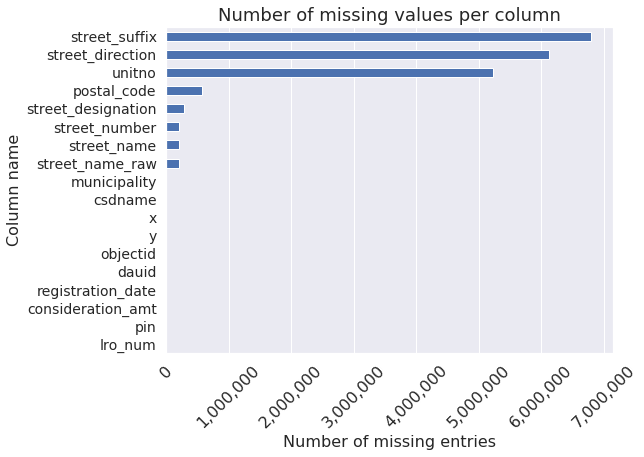

In [81]:
na_count = df.isnull().sum().sort_values()

f, ax = plt.subplots(1, figsize=(8, 6))
na_count.plot(kind='barh', ax=ax)
ax.grid(axis='y')
plt.xticks(rotation=45, fontsize=16)
plt.yticks(fontsize=14)
ax.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_title("Number of missing values per column", fontsize=18)
ax.set_ylabel("Column name", fontsize=16)
ax.set_xlabel("Number of missing entries", fontsize=16)
plt.savefig('results/teranet_na_count.png', dpi=400, bbox_inches='tight')

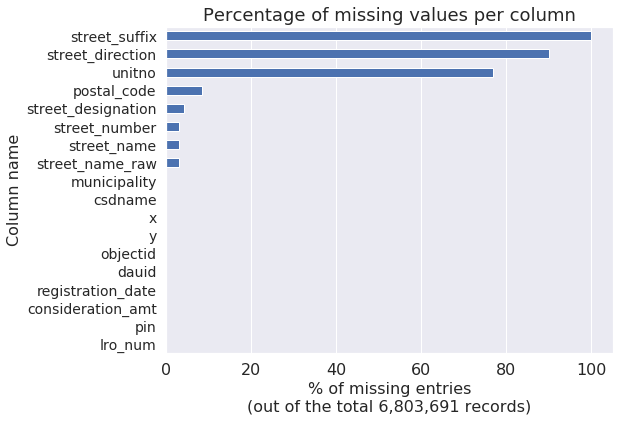

In [82]:
na_perc = df.isnull().sum().sort_values() / len(df) * 100

f, ax = plt.subplots(1, figsize=(8, 6))
na_perc.plot(kind='barh', ax=ax)
ax.grid(axis='y')
plt.xticks(fontsize=16)
plt.yticks(fontsize=14)
ax.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_title("Percentage of missing values per column", fontsize=18)
ax.set_ylabel("Column name", fontsize=16)
ax.set_xlabel("% of missing entries\n(out of the total {0:,} records)"
              .format(len(df)), fontsize=16)
plt.savefig('results/teranet_na_perc.png', dpi=400, bbox_inches='tight')

## Step 13: Remove column `street_suffix`
Since 99.99994% of the values in column `street_suffix` are missing, it has been removed from the dataset.

In [83]:
df = df.drop('street_suffix', axis=1)
print("Column 'street_suffix' was removed from the dataset.")

Column 'street_suffix' was removed from the dataset.


## Step 14: fix inconsistent values
Inconsistent entries are fixed in the following columns:
* Step 14.1: `street_direction`
* Step 14.2: `street_designaction`
* Step 14.3: `municipality`
* Step 14.4: `street_name`
* Step 14.5: `unitno`

### Step 14.1: Fix inconsistent values in column `street_direction`
Two Teranet records have `street_direction` = 'ES'. As it is unclear what should that correspond to (records correspond to the two transactions coming from some remote area north of Milton), their `street_direction` is reset to NaN (missing). Thus, `street_direction` for all Teranet records can be encoded as a singe character (catergory) that is either 'W', 'E', 'S', 'N', or NaN (missing).

In [84]:
df['street_direction'].value_counts()

W        316489
E        219818
N         70161
S         51637
West      11403
East       9193
North      2816
South      1607
N.          191
WEST        115
W.            6
ES            2
E.            2
NORTH         1
Name: street_direction, dtype: int64

#### Reset 'ES' to NaN

In [85]:
mask1 = df['street_direction'].str.match('ES', case=False, na=False)
df.loc[mask1, 'street_direction'].value_counts()

ES    2
Name: street_direction, dtype: int64

In [86]:
df.loc[mask1, 'street_direction'] = np.nan
df.loc[mask1, 'street_direction'].value_counts()

Series([], Name: street_direction, dtype: int64)

#### 'W'

In [87]:
mask1 = df['street_direction'].str.match('^W', case=False, na=False)
df.loc[mask1, 'street_direction'].value_counts()

W       316489
West     11403
WEST       115
W.           6
Name: street_direction, dtype: int64

In [88]:
df.loc[mask1, 'street_direction'] = 'W'
df.loc[mask1, 'street_direction'].value_counts()

W    328013
Name: street_direction, dtype: int64

#### 'E'

In [89]:
mask1 = df['street_direction'].str.match('^E', case=False, na=False)
df.loc[mask1, 'street_direction'].value_counts()

E       219818
East      9193
E.           2
Name: street_direction, dtype: int64

In [90]:
df.loc[mask1, 'street_direction'] = 'E'
df.loc[mask1, 'street_direction'].value_counts()

E    229013
Name: street_direction, dtype: int64

#### 'N'

In [91]:
mask1 = df['street_direction'].str.match('^N', case=False, na=False)
df.loc[mask1, 'street_direction'].value_counts()

N        70161
North     2816
N.         191
NORTH        1
Name: street_direction, dtype: int64

In [92]:
df.loc[mask1, 'street_direction'] = 'N'
df.loc[mask1, 'street_direction'].value_counts()

N    73169
Name: street_direction, dtype: int64

#### 'S'

In [93]:
mask1 = df['street_direction'].str.match('^S', case=False, na=False)
df.loc[mask1, 'street_direction'].value_counts()

S        51637
South     1607
Name: street_direction, dtype: int64

In [94]:
df.loc[mask1, 'street_direction'] = 'S'
df.loc[mask1, 'street_direction'].value_counts()

S    53244
Name: street_direction, dtype: int64

#### All inconsistent entries in column `street_direction` have been fixed.

In [95]:
df['street_direction'].value_counts()

W    328013
E    229013
N     73169
S     53244
Name: street_direction, dtype: int64

### Step 14.2: Fix inconsistent values in column `street_designation`
Street types were corrected in accordance with the [list of symbols and abbreviations](https://www.canadapost.ca/tools/pg/manual/PGaddress-e.asp?ecid=murl10006450) recognized by Canada Post. Only the values that needed correction are presented.

#### Abbey

In [96]:
mask1 = df['street_designation'].str.contains('Ab', case=False, na=False)
df.loc[mask1, 'street_designation'].value_counts()

Abbey    11
Abe       4
Name: street_designation, dtype: int64

In [97]:
df.loc[mask1, 'street_designation'] = 'Abbey'
df.loc[mask1, 'street_designation'].value_counts()

Abbey    15
Name: street_designation, dtype: int64

#### Ave

In [98]:
mask1 = df['street_designation'].str.contains('Av', case=False, na=False)
df.loc[mask1, 'street_designation'].value_counts()

Ave       1125986
Avenue      31474
Av           2061
Ave 5           2
Name: street_designation, dtype: int64

In [99]:
df.loc[mask1, 'street_designation'] = 'Ave'
df.loc[mask1, 'street_designation'].value_counts()

Ave    1159523
Name: street_designation, dtype: int64

#### Blvd

In [100]:
mask1 = df['street_designation'].str.contains('(bl|bo)', case=False, na=False)
df.loc[mask1, 'street_designation'].value_counts()

/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  """Entry point for launching an IPython kernel.


Blvd         325269
Boulevard     14041
Name: street_designation, dtype: int64

In [101]:
df.loc[mask1, 'street_designation'] = 'Blvd'
df.loc[mask1, 'street_designation'].value_counts()

Blvd    339310
Name: street_designation, dtype: int64

#### Cir

In [102]:
mask1 = df['street_designation'].str.contains('(cir$|circl)', case=False, na=False)
df.loc[mask1, 'street_designation'].value_counts()

/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  """Entry point for launching an IPython kernel.


Cir       133367
Circle      5616
Name: street_designation, dtype: int64

In [103]:
df.loc[mask1, 'street_designation'] = 'Cir'
df.loc[mask1, 'street_designation'].value_counts()

Cir    138983
Name: street_designation, dtype: int64

#### Crt

In [104]:
mask1 = df['street_designation'].str.contains('(Crt|Cou)', case=False, na=False)
df.loc[mask1, 'street_designation'].value_counts()

/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  """Entry point for launching an IPython kernel.


Crt      299387
Court     10876
Name: street_designation, dtype: int64

In [105]:
df.loc[mask1, 'street_designation'] = 'Crt'
df.loc[mask1, 'street_designation'].value_counts()

Crt    310263
Name: street_designation, dtype: int64

#### Cres

In [106]:
mask1 = df['street_designation'].str.contains('^Cre', case=False, na=False)
df.loc[mask1, 'street_designation'].value_counts()

Cres        662212
Crescent     28068
Cresent         74
Name: street_designation, dtype: int64

In [107]:
df.loc[mask1, 'street_designation'] = 'Cres'
df.loc[mask1, 'street_designation'].value_counts()

Cres    690354
Name: street_designation, dtype: int64

#### Dell

In [108]:
mask1 = df['street_designation'].str.contains('^de', case=False, na=False)
df.loc[mask1, 'street_designation'].value_counts()

Dell    19
De       2
Name: street_designation, dtype: int64

In [109]:
df.loc[mask1, 'street_designation'] = 'Dell'
df.loc[mask1, 'street_designation'].value_counts()

Dell    21
Name: street_designation, dtype: int64

#### Dr

In [110]:
mask1 = df['street_designation'].str.contains('Dr', case=False, na=False)
df.loc[mask1, 'street_designation'].value_counts()

Dr          1076089
Drive         39475
Driveway       1997
Name: street_designation, dtype: int64

In [111]:
df.loc[mask1, 'street_designation'] = 'Dr'
df.loc[mask1, 'street_designation'].value_counts()

Dr    1117561
Name: street_designation, dtype: int64

#### Espl

In [112]:
mask1 = df['street_designation'].str.contains('^es', case=False, na=False)
df.loc[mask1, 'street_designation'].value_counts()

Espl         8296
Esplanade    3487
Name: street_designation, dtype: int64

In [113]:
df.loc[mask1, 'street_designation'] = 'Espl'
df.loc[mask1, 'street_designation'].value_counts()

Espl    11783
Name: street_designation, dtype: int64

#### Landing

In [114]:
mask1 = df['street_designation'].str.contains('^land', case=False, na=False)
df.loc[mask1, 'street_designation'].value_counts()

Landng     1272
Landing       2
Name: street_designation, dtype: int64

In [115]:
df.loc[mask1, 'street_designation'] = 'Landng'
df.loc[mask1, 'street_designation'].value_counts()

Landng    1274
Name: street_designation, dtype: int64

#### Lane

In [116]:
mask1 = df['street_designation'].str.contains('(lane|lanes|ln)', case=False, na=False)
df.loc[mask1, 'street_designation'].value_counts()

/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  """Entry point for launching an IPython kernel.


Lane     109029
Lanes        86
Ln           13
Name: street_designation, dtype: int64

In [117]:
df.loc[mask1, 'street_designation'] = 'Lane'
df.loc[mask1, 'street_designation'].value_counts()

Lane    109128
Name: street_designation, dtype: int64

#### Link

In [118]:
mask1 = df['street_designation'].str.contains('link', case=False, na=False)
df.loc[mask1, 'street_designation'].value_counts()

Linkway    2458
Link         32
Name: street_designation, dtype: int64

In [119]:
df.loc[mask1, 'street_designation'] = 'Link'
df.loc[mask1, 'street_designation'].value_counts()

Link    2490
Name: street_designation, dtype: int64

#### Pky

In [120]:
mask1 = df['street_designation'].str.contains('(parkw|pky|pkwy)', case=False, na=False)
df.loc[mask1, 'street_designation'].value_counts()

/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  """Entry point for launching an IPython kernel.


Pky        20790
Pkwy           9
Parkway        8
Name: street_designation, dtype: int64

In [121]:
df.loc[mask1, 'street_designation'] = 'Pky'
df.loc[mask1, 'street_designation'].value_counts()

Pky    20807
Name: street_designation, dtype: int64

#### Pl

In [122]:
mask1 = df['street_designation'].str.contains('(^Pl$|Place)', case=False, na=False)
df.loc[mask1, 'street_designation'].value_counts()

/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  """Entry point for launching an IPython kernel.


Pl       117619
Place      2963
Name: street_designation, dtype: int64

In [123]:
df.loc[mask1, 'street_designation'] = 'Pl'
df.loc[mask1, 'street_designation'].value_counts()

Pl    120582
Name: street_designation, dtype: int64

#### Rd

In [124]:
mask1 = df['street_designation'].str.contains('(rd|roa)', case=False, na=False)
df.loc[mask1, 'street_designation'].value_counts()

/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  """Entry point for launching an IPython kernel.


Rd           884415
Road          48233
Sideroad       3685
Side rd        3118
Side road        83
Rd 30             5
Rd w              2
Name: street_designation, dtype: int64

In [125]:
df.loc[mask1, 'street_designation'] = 'Rd'
df.loc[mask1, 'street_designation'].value_counts()

Rd    939541
Name: street_designation, dtype: int64

#### St

In [126]:
mask1 = df['street_designation'].str.contains('^St', case=False, na=False)
df.loc[mask1, 'street_designation'].value_counts()

St        1018773
Street      47626
Name: street_designation, dtype: int64

In [127]:
df.loc[mask1, 'street_designation'] = 'St'
df.loc[mask1, 'street_designation'].value_counts()

St    1066399
Name: street_designation, dtype: int64

#### Sq

In [128]:
mask1 = df['street_designation'].str.contains('Sq', case=False, na=False)
df.loc[mask1, 'street_designation'].value_counts()

Sq        47098
Square     1937
Name: street_designation, dtype: int64

In [129]:
df.loc[mask1, 'street_designation'] = 'Sq'
df.loc[mask1, 'street_designation'].value_counts()

Sq    49035
Name: street_designation, dtype: int64

#### Terr

In [130]:
mask1 = df['street_designation'].str.contains('Terr', case=False, na=False)
df.loc[mask1, 'street_designation'].value_counts()

Terr       31332
Terrace     1147
Name: street_designation, dtype: int64

In [131]:
df.loc[mask1, 'street_designation'] = 'Terr'
df.loc[mask1, 'street_designation'].value_counts()

Terr    32479
Name: street_designation, dtype: int64

#### Terr

In [132]:
mask1 = df['street_designation'].str.contains('(Tra|Trl)', case=False, na=False)
df.loc[mask1, 'street_designation'].value_counts()

/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  """Entry point for launching an IPython kernel.


Trail    80732
Trl          4
Name: street_designation, dtype: int64

In [133]:
df.loc[mask1, 'street_designation'] = 'Trail'
df.loc[mask1, 'street_designation'].value_counts()

Trail    80736
Name: street_designation, dtype: int64

#### Vale

In [134]:
mask1 = df['street_designation'].str.contains('Val', case=False, na=False)
df.loc[mask1, 'street_designation'].value_counts()

Vallee    105
Vale      101
Name: street_designation, dtype: int64

In [135]:
df.loc[mask1, 'street_designation'] = 'Vale'
df.loc[mask1, 'street_designation'].value_counts()

Vale    206
Name: street_designation, dtype: int64

#### Correct erratic entries: 48 refers to Highway 48

In [136]:
mask1 = df['street_designation'] == '48'
df[mask1]

,lro_num,pin,consideration_amt,registration_date,postal_code,unitno,street_name,street_designation,street_direction,municipality,street_number,x,y,objectid,dauid,csdname,street_name_raw
706261,65,35430323,280000.0,2009-08-07,NaN,NaN,Highway,48,NaN,Georgina,27483,-79.304461,44.309741,150,35191146,Georgina,Highway
706310,65,35430323,315000.0,2013-05-30,NaN,NaN,Highway,48,NaN,Georgina,27483,-79.304461,44.309741,150,35191146,Georgina,Highway
706383,65,35430323,270000.0,2003-03-05,NaN,NaN,Highway,48,NaN,Georgina,27483,-79.304461,44.309741,150,35191146,Georgina,Highway
706447,65,35430323,295000.0,2006-11-15,NaN,NaN,Highway,48,NaN,Georgina,27483,-79.304461,44.309741,150,35191146,Georgina,Highway


In [137]:
df.loc[mask1, 'street_designation'] = 'Highway'
df.loc[mask1, 'street_name'] = 'Highway 48'
df.loc[mask1]

,lro_num,pin,consideration_amt,registration_date,postal_code,unitno,street_name,street_designation,street_direction,municipality,street_number,x,y,objectid,dauid,csdname,street_name_raw
706261,65,35430323,280000.0,2009-08-07,NaN,NaN,Highway 48,Highway,NaN,Georgina,27483,-79.304461,44.309741,150,35191146,Georgina,Highway
706310,65,35430323,315000.0,2013-05-30,NaN,NaN,Highway 48,Highway,NaN,Georgina,27483,-79.304461,44.309741,150,35191146,Georgina,Highway
706383,65,35430323,270000.0,2003-03-05,NaN,NaN,Highway 48,Highway,NaN,Georgina,27483,-79.304461,44.309741,150,35191146,Georgina,Highway
706447,65,35430323,295000.0,2006-11-15,NaN,NaN,Highway 48,Highway,NaN,Georgina,27483,-79.304461,44.309741,150,35191146,Georgina,Highway


#### Correct erratic entries: Ctr refers to South Town Centre Blvd in Markham

In [138]:
mask1 = df['street_designation'].str.match('ctr', case=False, na=False)
df[mask1]

,lro_num,pin,consideration_amt,registration_date,postal_code,unitno,street_name,street_designation,street_direction,municipality,street_number,x,y,objectid,dauid,csdname,street_name_raw
4940473,65,298440671,29000000.0,2007-12-18,NaN,611,South Town,Ctr,NaN,Markham,89,-79.336688,43.852045,1387,35190747,Markham,South Town
4940811,65,298440700,29000000.0,2007-12-18,NaN,901,South Town,Ctr,NaN,Markham,89,-79.336688,43.852045,1387,35190747,Markham,South Town
4941118,65,298440651,29000000.0,2007-12-18,NaN,901,South Town,Ctr,NaN,Markham,89,-79.336688,43.852045,1387,35190747,Markham,South Town
4941266,65,298440963,29000000.0,2007-12-18,NaN,107,South Town,Ctr,NaN,Markham,99,-79.336688,43.852045,1387,35190747,Markham,South Town
4947094,65,298440700,282320.0,2012-01-27,NaN,901,South Town,Ctr,NaN,Markham,89,-79.336688,43.852045,1387,35190747,Markham,South Town
4947384,65,298440671,282320.0,2012-01-27,NaN,611,South Town,Ctr,NaN,Markham,89,-79.336688,43.852045,1387,35190747,Markham,South Town
4947704,65,298440963,282320.0,2012-01-27,NaN,107,South Town,Ctr,NaN,Markham,99,-79.336688,43.852045,1387,35190747,Markham,South Town
4947934,65,298440651,282320.0,2012-01-27,NaN,901,South Town,Ctr,NaN,Markham,89,-79.336688,43.852045,1387,35190747,Markham,South Town
4948410,65,298440700,2.0,2012-06-01,NaN,901,South Town,Ctr,NaN,Markham,89,-79.336688,43.852045,1387,35190747,Markham,South Town
4948473,65,298440671,2.0,2012-06-01,NaN,611,South Town,Ctr,NaN,Markham,89,-79.336688,43.852045,1387,35190747,Markham,South Town


In [139]:
df.loc[mask1, 'street_designation'] = 'Blvd'
df.loc[mask1, 'street_name'] = 'South Town Centre'
df.loc[mask1]

,lro_num,pin,consideration_amt,registration_date,postal_code,unitno,street_name,street_designation,street_direction,municipality,street_number,x,y,objectid,dauid,csdname,street_name_raw
4940473,65,298440671,29000000.0,2007-12-18,NaN,611,South Town Centre,Blvd,NaN,Markham,89,-79.336688,43.852045,1387,35190747,Markham,South Town
4940811,65,298440700,29000000.0,2007-12-18,NaN,901,South Town Centre,Blvd,NaN,Markham,89,-79.336688,43.852045,1387,35190747,Markham,South Town
4941118,65,298440651,29000000.0,2007-12-18,NaN,901,South Town Centre,Blvd,NaN,Markham,89,-79.336688,43.852045,1387,35190747,Markham,South Town
4941266,65,298440963,29000000.0,2007-12-18,NaN,107,South Town Centre,Blvd,NaN,Markham,99,-79.336688,43.852045,1387,35190747,Markham,South Town
4947094,65,298440700,282320.0,2012-01-27,NaN,901,South Town Centre,Blvd,NaN,Markham,89,-79.336688,43.852045,1387,35190747,Markham,South Town
4947384,65,298440671,282320.0,2012-01-27,NaN,611,South Town Centre,Blvd,NaN,Markham,89,-79.336688,43.852045,1387,35190747,Markham,South Town
4947704,65,298440963,282320.0,2012-01-27,NaN,107,South Town Centre,Blvd,NaN,Markham,99,-79.336688,43.852045,1387,35190747,Markham,South Town
4947934,65,298440651,282320.0,2012-01-27,NaN,901,South Town Centre,Blvd,NaN,Markham,89,-79.336688,43.852045,1387,35190747,Markham,South Town
4948410,65,298440700,2.0,2012-06-01,NaN,901,South Town Centre,Blvd,NaN,Markham,89,-79.336688,43.852045,1387,35190747,Markham,South Town
4948473,65,298440671,2.0,2012-06-01,NaN,611,South Town Centre,Blvd,NaN,Markham,89,-79.336688,43.852045,1387,35190747,Markham,South Town


#### All inconsistent entries in column `street_designation` have been fixed.

### Step 14.3: Fix inconsistent values in column `municipality`
`municipality` values were corrected in accordance with the 27 municipality names used for Dissemination Areas (DAs), as can be found in column `csdname` that was added to Teranet records via the spatial join performed during _Step 2.1_ of the cleanup process. Teranet records have a lot more different `municipality` names, such as 'York', 'East York', 'North York', 'Etobicoke', or smaller towns in GTHA, these values were left untouched; `municipality` names corresponding to major GTHA municipalities, that are used for DAs and can be found in column `csdname`, have been corrected to match the spelling found in Census datasets. 

In [140]:
df['csdname'].value_counts()

Toronto                          2785057
Mississauga                       703798
Brampton                          495970
Hamilton                          482655
Markham                           314783
Vaughan                           305211
Richmond Hill                     214837
Oakville                          210181
Burlington                        208953
Oshawa                            134040
Whitby                            110045
Milton                             94193
Ajax                               88102
Clarington                         86850
Caledon                            86725
Pickering                          86694
Newmarket                          73254
Halton Hills                       61429
Georgina                           59913
Aurora                             53802
Whitchurch-Stouffville             40717
King                               24894
Scugog                             23834
East Gwillimbury                   23568
Uxbridge        

### Toronto

In [141]:
mask1 = df['municipality'].str.contains('Toro', na=False, case=False)
df.loc[mask1, 'municipality'].value_counts()

Toronto               1778555
North York/Toronto        168
City Of Toronto            57
Islington/Toronto           3
Name: municipality, dtype: int64

In [142]:
df.loc[mask1, 'municipality'] = 'Toronto'
df.loc[mask1, 'municipality'].value_counts()

Toronto    1778783
Name: municipality, dtype: int64

### Mississauga

In [143]:
mask1 = df['municipality'].str.contains('Mis', na=False, case=False)
mask2 = df['municipality'].str.contains('\sof\s', na=False, case=False)
df.loc[mask1 & ~mask2, 'municipality'].value_counts()

Mississauga     703492
Mississsauga         2
Name: municipality, dtype: int64

In [144]:
df.loc[mask1 & ~mask2, 'municipality'] = 'Mississauga'
df.loc[mask1 & ~mask2, 'municipality'].value_counts()

Mississauga    703494
Name: municipality, dtype: int64

### Hamilton

In [145]:
mask1 = df['municipality'].str.contains('hami', na=False, case=False)
df.loc[mask1, 'municipality'].value_counts()

Hamilton            392099
Rural Hamilton        1214
City Of Hamilton       327
Hamilton City            2
Name: municipality, dtype: int64

In [146]:
df.loc[mask1, 'municipality'] = 'Hamilton'
df.loc[mask1, 'municipality'].value_counts()

Hamilton    393642
Name: municipality, dtype: int64

### Markham
#### Whit-Stouffville/Markham
Teranet records that have `municipality` value of 'Whit-Stouffville/Markham' are located in 'Whitchurch-Stouffville' according to their coordinates.

In [147]:
mask1 = df['municipality'] == 'Whit-Stouffville/Markham'
df.loc[mask1, ['municipality', 'csdname', 'y', 'x']]

,municipality,csdname,y,x
819518,Whit-Stouffville/Markham,Whitchurch-Stouffville,43.936371,-79.380210
819992,Whit-Stouffville/Markham,Whitchurch-Stouffville,43.936371,-79.380210
905573,Whit-Stouffville/Markham,Whitchurch-Stouffville,44.083982,-79.343559
1323322,Whit-Stouffville/Markham,Whitchurch-Stouffville,43.974472,-79.231358


In [148]:
df.loc[mask1, 'municipality'] = 'Whitchurch-Stouffville'
df.loc[mask1, 'municipality'].value_counts()

Whitchurch-Stouffville    4
Name: municipality, dtype: int64

#### Markham

In [149]:
mask1 = df['municipality'].str.contains('markh', na=False, case=False)
df.loc[mask1, 'municipality'].value_counts()

Markham            258678
City Of Markham         6
Name: municipality, dtype: int64

In [150]:
df.loc[mask1, 'municipality'] = 'Markham'
df.loc[mask1, 'municipality'].value_counts()

Markham    258684
Name: municipality, dtype: int64

### Caledon

In [151]:
mask1 = df['municipality'].str.contains('(caledon$|caledon\s)', na=False, case=False)
df.loc[mask1, 'municipality'].value_counts()

/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  """Entry point for launching an IPython kernel.


Caledon            80549
Caledon East         338
Caledon Village       38
East Caledon           2
Name: municipality, dtype: int64

In [152]:
df.loc[mask1, 'municipality'] = 'Caledon'
df.loc[mask1, 'municipality'].value_counts()

Caledon    80927
Name: municipality, dtype: int64

### Pickering

In [153]:
mask1 = df['municipality'].str.contains('pick', na=False, case=False)
df.loc[mask1, 'municipality'].value_counts()

Pickering         86258
Pickering City        4
Name: municipality, dtype: int64

In [154]:
df.loc[mask1, 'municipality'] = 'Pickering'
df.loc[mask1, 'municipality'].value_counts()

Pickering    86262
Name: municipality, dtype: int64

### Newmarket

In [155]:
mask1 = df['municipality'].str.contains('newm', na=False, case=False)
df.loc[mask1, 'municipality'].value_counts()

Newmarket             71923
Newmarket Township     2310
Name: municipality, dtype: int64

In [156]:
df.loc[mask1, 'municipality'] = 'Newmarket'
df.loc[mask1, 'municipality'].value_counts()

Newmarket    74233
Name: municipality, dtype: int64

### Halton Hills
`municipality` value 'Halton' seems to correspond to a number of municipalities (Milton, Oakville, Halton Hills), as indicated by correcsponding values of `csdname`, and is left unchanged.

In [157]:
mask1 = df['municipality'].str.contains('halton\s', na=False, case=False)
df.loc[mask1, 'municipality'].value_counts()

Halton Hills    50528
Halton Hill         3
Name: municipality, dtype: int64

In [158]:
df.loc[mask1, 'municipality'] = 'Halton Hills'
df.loc[mask1, 'municipality'].value_counts()

Halton Hills    50531
Name: municipality, dtype: int64

### Georgina

In [159]:
mask1 = df['municipality'].str.contains('georgi', na=False, case=False)
df.loc[mask1, 'municipality'].value_counts()

Georgina            35308
Town Of Georgina        9
Name: municipality, dtype: int64

In [160]:
df.loc[mask1, 'municipality'] = 'Georgina'
df.loc[mask1, 'municipality'].value_counts()

Georgina    35317
Name: municipality, dtype: int64

### Whitchurch-Stouffville

In [161]:
mask1 = df['municipality'].str.contains('(whitc|stou)', na=False, case=False)
df.loc[mask1, 'municipality'].value_counts()

/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  """Entry point for launching an IPython kernel.


Whitchurch-Stouffville      20264
Stouffville                 16652
Whitchurch - Stouffville     2758
Whitchurch/Stouffville         23
Whitchurch                      2
Name: municipality, dtype: int64

In [162]:
df.loc[mask1, 'municipality'] = 'Whitchurch-Stouffville'
df.loc[mask1, 'municipality'].value_counts()

Whitchurch-Stouffville    39699
Name: municipality, dtype: int64

### King

In [163]:
mask1 = df['municipality'].str.contains('(king$|king\s)', na=False, case=False)
df.loc[mask1, 'municipality'].value_counts()

/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  """Entry point for launching an IPython kernel.


King             10246
King City         6874
King Township     2699
Name: municipality, dtype: int64

In [164]:
df.loc[mask1, 'municipality'] = 'King'
df.loc[mask1, 'municipality'].value_counts()

King    19819
Name: municipality, dtype: int64

### Scugog

In [165]:
mask1 = df['municipality'].str.contains('scu', na=False, case=False)
mask2 = df['municipality'].str.contains('mississ', na=False, case=False)
df.loc[mask1 & ~mask2, 'municipality'].value_counts()

Scugog             16005
Scugog Township     2445
Name: municipality, dtype: int64

In [166]:
df.loc[mask1, 'municipality'] = 'Scugog'
df.loc[mask1, 'municipality'].value_counts()

Scugog    18456
Name: municipality, dtype: int64

### Uxbridge

In [167]:
mask1 = df['municipality'].str.contains('ux', na=False, case=False)
df.loc[mask1, 'municipality'].value_counts()

Uxbridge             18704
Uxbridge Township     1641
Name: municipality, dtype: int64

In [168]:
df.loc[mask1, 'municipality'] = 'Uxbridge'
df.loc[mask1, 'municipality'].value_counts()

Uxbridge    20345
Name: municipality, dtype: int64

### Brock

In [169]:
mask1 = df['municipality'].str.contains('brock$|brock\s', na=False, case=False)
df.loc[mask1, 'municipality'].value_counts()

Brock             7622
Brock Township    3953
Name: municipality, dtype: int64

In [170]:
df.loc[mask1, 'municipality'] = 'Brock'
df.loc[mask1, 'municipality'].value_counts()

Brock    11575
Name: municipality, dtype: int64

### Step 14.4: Inconsistent values in column `street_name`
Consistency of entries in column `street_name` was improved through parsing out zip codes, unit and street numbers, street directions and street designations in the previous steps. Corrections for most frequently encountered street names are made in this subsection.

In [171]:
df['street_name'].value_counts()

Yonge                                82528
King                                 46727
Sheppard                             36154
Bay                                  35939
Lakeshore                            32420
Eglinton                             29127
Queens                               27818
Bloor                                26064
Lake Shore                           24647
Bayview                              22205
Dundas                               21262
Harrison Garden                      20746
Queen                                20236
Hillcrest                            18882
Front                                18832
Bamburgh                             17666
Lee Centre                           17505
Kingsbridge Garden                   17440
Finch                                17366
Webb                                 16792
Richmond                             16786
Bathurst                             16716
Mill                                 16597
Main       

#### Yonge St

In [172]:
mask1 = df['street_name'].str.contains('yonge\ss', na=False, case=False)
mask2 = df['street_name'].str.contains('(,|Tower|\/)', na=False, case=False)
df.loc[mask1 & ~mask2, 'street_name'].value_counts()

/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  


Yonge Street                       89
Yonge Steet                         6
Yonge Street South Of Ravenshoe     5
Yonge Stree                         5
Yonge Street Ric                    2
Yonge Strret                        1
Yonge Sstreet                       1
Yonge Steeet                        1
Name: street_name, dtype: int64

In [173]:
df.loc[mask1 & ~mask2, 'street_name'] = 'Yonge'
df.loc[mask1 & ~mask2, 'street_designation'] = 'St'
df.loc[mask1 & ~mask2, 'street_name'].value_counts()

Yonge    110
Name: street_name, dtype: int64

#### King St

In [174]:
mask1 = df['street_name'].str.contains('king\sstreet$|king\sst$|king\sst\.|king\sstreet,$', na=False, case=False)
df.loc[mask1, 'street_name'].value_counts()

King Street     40
King St          8
King St.         3
King Street,     2
Name: street_name, dtype: int64

In [175]:
df.loc[mask1, 'street_name'] = 'King'
df.loc[mask1, 'street_designation'] = 'St'
df.loc[mask1, 'street_name'].value_counts()

King    53
Name: street_name, dtype: int64

#### Sheppard Ave

##### Fix street directions

In [176]:
mask1 = df['street_name'] == "Sheppard AveE."
df.loc[mask1, ['unitno', 'street_number', 'street_name', 'street_direction', 'municipality', 'y', 'x']]

,unitno,street_number,street_name,street_direction,municipality,y,x
536453,NaN,200,Sheppard AveE.,NaN,Willowdale,43.763833,-79.401759
536454,NaN,200,Sheppard AveE.,NaN,Willowdale,43.763833,-79.401759
536462,NaN,200,Sheppard AveE.,NaN,Willowdale,43.763833,-79.401759
536481,NaN,222,Sheppard AveE.,NaN,Willowdale,43.764049,-79.400651
536513,NaN,218,Sheppard AveE.,NaN,Willowdale,43.763952,-79.401102
536683,NaN,218,Sheppard AveE.,NaN,Willowdale,43.763952,-79.401102
536773,NaN,222,Sheppard AveE.,NaN,Willowdale,43.764049,-79.400651
536914,NaN,200,Sheppard AveE.,NaN,Willowdale,43.763833,-79.401759
536924,NaN,218,Sheppard AveE.,NaN,Willowdale,43.763952,-79.401102
813455,NaN,166,Sheppard AveE.,NaN,Willowdale,43.764131,-79.404090


In [177]:
df.loc[mask1, 'street_direction'] = 'E'
df.loc[mask1, ['unitno', 'street_number', 'street_name', 'street_direction', 'municipality', 'y', 'x']]

,unitno,street_number,street_name,street_direction,municipality,y,x
536453,NaN,200,Sheppard AveE.,E,Willowdale,43.763833,-79.401759
536454,NaN,200,Sheppard AveE.,E,Willowdale,43.763833,-79.401759
536462,NaN,200,Sheppard AveE.,E,Willowdale,43.763833,-79.401759
536481,NaN,222,Sheppard AveE.,E,Willowdale,43.764049,-79.400651
536513,NaN,218,Sheppard AveE.,E,Willowdale,43.763952,-79.401102
536683,NaN,218,Sheppard AveE.,E,Willowdale,43.763952,-79.401102
536773,NaN,222,Sheppard AveE.,E,Willowdale,43.764049,-79.400651
536914,NaN,200,Sheppard AveE.,E,Willowdale,43.763833,-79.401759
536924,NaN,218,Sheppard AveE.,E,Willowdale,43.763952,-79.401102
813455,NaN,166,Sheppard AveE.,E,Willowdale,43.764131,-79.404090


In [178]:
mask1 = df['street_name'] == "Sheppard AveW."
df.loc[mask1, ['unitno', 'street_number', 'street_name', 'street_direction', 'municipality', 'y', 'x']]

,unitno,street_number,street_name,street_direction,municipality,y,x
1652608,NaN,115,Sheppard AveW.,NaN,North York,43.759937,-79.416730
1652821,NaN,133,Sheppard AveW.,NaN,Willowdale,43.759736,-79.417652
1652875,NaN,137,Sheppard AveW.,NaN,North York,43.759712,-79.417744
1652878,NaN,115,Sheppard AveW.,NaN,North York,43.759937,-79.416730
1652894,NaN,109,Sheppard AveW.,NaN,North York,43.760000,-79.416439


In [179]:
df.loc[mask1, 'street_direction'] = 'W'
df.loc[mask1, ['unitno', 'street_number', 'street_name', 'street_direction', 'municipality', 'y', 'x']]

,unitno,street_number,street_name,street_direction,municipality,y,x
1652608,NaN,115,Sheppard AveW.,W,North York,43.759937,-79.416730
1652821,NaN,133,Sheppard AveW.,W,Willowdale,43.759736,-79.417652
1652875,NaN,137,Sheppard AveW.,W,North York,43.759712,-79.417744
1652878,NaN,115,Sheppard AveW.,W,North York,43.759937,-79.416730
1652894,NaN,109,Sheppard AveW.,W,North York,43.760000,-79.416439


##### Fix street name and street designation

In [180]:
mask1 = df['street_name'].str.contains('sheppard av', na=False, case=False)
mask2 = df['street_name'].str.contains('\(', na=False, case=False)
df.loc[mask1 & ~mask2, 'street_name'].value_counts()

Sheppard Avenue    91
Sheppard AveE.     13
Sheppard Ave        7
Sheppard AveW.      5
Name: street_name, dtype: int64

In [181]:
df.loc[mask1, 'street_name'] = 'Sheppard'
df.loc[mask1, 'street_designation'] = 'Ave'
df.loc[mask1, 'street_name'].value_counts()

Sheppard    119
Name: street_name, dtype: int64

#### Bloor St

##### Fix street number

In [182]:
mask1 = df['street_name'].str.contains('^bloor\ss', na=False, case=False)
mask2 = df['street_name'].str.contains('\se', na=False, case=False)
mask3 = df['street_name'].str.contains('#', na=False)
df.loc[mask1 & mask2 & mask3, 'street_name'].value_counts()

Bloor Street East, #807    1
Name: street_name, dtype: int64

In [183]:
df.loc[mask1 & mask2 & mask3, 'street_number'] = 807
print("Street number fixed!")

Street number fixed!


##### Fix street direction

In [184]:
mask1 = df['street_name'].str.contains('^bloor\ss', na=False, case=False)
mask2 = df['street_name'].str.contains('\se', na=False, case=False)
df.loc[mask1 & mask2, 'street_name'].value_counts()

Bloor St Est               2
Bloor Street East, #807    1
Bloor Street East`         1
Bloor Street Est           1
Name: street_name, dtype: int64

In [185]:
df.loc[mask1 & mask2, 'street_direction'] = 'E'
print("Street direction fixed!")

Street direction fixed!


##### Fix street name and street designation

In [186]:
mask1 = df['street_name'].str.contains('^bloor\ss', na=False, case=False)
df.loc[mask1, 'street_name'].value_counts()

Bloor Streest              3
Bloor Sreet                2
Bloor St Est               2
Bloor Stree                2
Bloor Street East, #807    1
Bloor Street,              1
Bloor Streeat              1
Bloor Street East`         1
Bloor Street Est           1
Bloor Strret               1
Name: street_name, dtype: int64

In [187]:
df.loc[mask1, 'street_name'] = 'Bloor'
df.loc[mask1, 'street_designation'] = 'St'
df.loc[mask1, 'street_name'].value_counts()

Bloor    15
Name: street_name, dtype: int64

#### Dundas St

In [188]:
mask1 = df['street_name'].str.contains('^Dundas\ss$|^dundas\sst', na=False, case=False)
df.loc[mask1, 'street_name'].value_counts()

Dundas Street        21
Dundas St.            3
Dundas Street,        2
Dundas St             1
Dundas St E Hwy 5     1
Dundas S              1
Name: street_name, dtype: int64

In [189]:
df.loc[mask1, 'street_name'] = 'Dundas'
df.loc[mask1, 'street_designation'] = 'St'
df.loc[mask1, 'street_name'].value_counts()

Dundas    29
Name: street_name, dtype: int64

#### Front St

In [190]:
mask1 = df['street_name'].str.contains('Front\s', na=False, case=False)
df.loc[mask1, 'street_name'].value_counts()

Front Street,    1
Front Stereet    1
Front Stree      1
Name: street_name, dtype: int64

In [191]:
df.loc[mask1, 'street_name'] = 'Front'
df.loc[mask1, 'street_designation'] = 'St'
df.loc[mask1, 'street_name'].value_counts()

Front    3
Name: street_name, dtype: int64

There are many more inconsistencies present in column `street_name`, but since fixing all of them presents a time-intensive task, it is left until a future stage when targeted corrections can be performed where required.

### Step 14.5: Fix values in column `unitno`

#### 1.010000e-107

In [192]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.contains('e')
mask2 = unit_no.str.match('1.01')
mask3 = unit_no.str.match('1.009')
df.loc[mask1 & (mask2 | mask3), 'unitno']

340618    1.01e-107
Name: unitno, dtype: object

In [193]:
df.loc[mask1 & (mask2 | mask3), 'unitno'] = 101
df.loc[mask1 & (mask2 | mask3), 'unitno']

340618    101
Name: unitno, dtype: object

#### 1.200000e-/+x
>It is impossible to tell, if this erratic unit number corresponds to '12', '120', or '1200'. All units that match this pattern have been converted to '12'.

In [194]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.contains('e')
mask2 = unit_no.str.match('1.199')
df.loc[mask1 & mask2, 'unitno']

3953588    1.2e-103
3953651    1.2e-200
3953674    1.2e-200
3953742    1.2e-200
3953776    1.2e-200
3954430    1.2e-200
3954537    1.2e-200
3954600    1.2e-200
3954633    1.2e-200
3954636    1.2e-103
3954679    1.2e-200
3954680    1.2e-200
3954682    1.2e-200
3954683    1.2e-200
3954756    1.2e-103
3955235    1.2e-103
Name: unitno, dtype: object

In [195]:
df.loc[mask1 & mask2, 'unitno'] = 12
df.loc[mask1 & mask2, 'unitno']

3953588    12
3953651    12
3953674    12
3953742    12
3953776    12
3954430    12
3954537    12
3954600    12
3954633    12
3954636    12
3954679    12
3954680    12
3954682    12
3954683    12
3954756    12
3955235    12
Name: unitno, dtype: object

#### 2.000000e-/+x
>It is impossible to tell, if this erratic unit number corresponds to '2', '20', or '200'. All units that match this pattern have been converted to '2'.

In [196]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.contains('e')
mask2 = unit_no.str.match('2')
mask3 = unit_no.str.match('1.99')
df.loc[mask1 & (mask2 | mask3), 'unitno']

803793      2e-22
804383      2e-22
804389      2e-22
976890     2e+105
980143     2e+155
980174     2e+155
985930     2e+105
1319468     2e-06
1319615     2e-05
1320010     2e-06
1745134     2e+18
1745135     2e+19
1745136     2e+21
1746261     2e+18
1746262     2e+19
1746263     2e+21
2898062    2e-123
2901764    2e-123
2902654    2e-123
4334081     2e-12
4334231     2e-12
4334306     2e-12
Name: unitno, dtype: object

In [197]:
df.loc[mask1 & (mask2 | mask3), 'unitno'] = 2
df.loc[mask1 & (mask2 | mask3), 'unitno']

803793     2
804383     2
804389     2
976890     2
980143     2
980174     2
985930     2
1319468    2
1319615    2
1320010    2
1745134    2
1745135    2
1745136    2
1746261    2
1746262    2
1746263    2
2898062    2
2901764    2
2902654    2
4334081    2
4334231    2
4334306    2
Name: unitno, dtype: object

#### 1.100000e-201
>It is impossible to tell, if this erratic unit number corresponds to '11', '110', or '1100'. All units that match this pattern have been converted to '11'.

In [198]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.contains('e')
mask2 = unit_no.str.match('1.1')
mask3 = unit_no.str.match('1.09')
df.loc[mask1 & (mask2 | mask3), 'unitno']

3953610    1.1e-201
3953628    1.1e-201
3953668    1.1e-201
3954463    1.1e-201
3954481    1.1e-201
3954512    1.1e-201
3954772    1.1e-201
3954773    1.1e-201
3954774    1.1e-201
3955395    1.1e-201
3955397    1.1e-201
3955398    1.1e-201
Name: unitno, dtype: object

In [199]:
df.loc[mask1 & (mask2 | mask3), 'unitno'] = 11
df.loc[mask1 & (mask2 | mask3), 'unitno']

3953610    11
3953628    11
3953668    11
3954463    11
3954481    11
3954512    11
3954772    11
3954773    11
3954774    11
3955395    11
3955397    11
3955398    11
Name: unitno, dtype: object

#### 1.700000e-06
>It is impossible to tell, if this erratic unit number corresponds to '17', '170', or '1700'. All units that match this pattern have been converted to '17'.

In [200]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.contains('e')
mask2 = unit_no.str.match('1.7')
mask3 = unit_no.str.match('1.69')
df.loc[mask1 & (mask2 | mask3), 'unitno']

1288104    1.7e-06
1288472    1.7e-06
Name: unitno, dtype: object

In [201]:
df.loc[mask1 & (mask2 | mask3), 'unitno'] = 17
df.loc[mask1 & (mask2 | mask3), 'unitno']

1288104    17
1288472    17
Name: unitno, dtype: object

#### 1.800000e-19
>It is impossible to tell, if this erratic unit number corresponds to '18', '180', or '1800'. All units that match this pattern have been converted to '18'.

In [202]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.contains('e')
mask2 = unit_no.str.match('1.8')
mask3 = unit_no.str.match('1.79')
df.loc[mask1 & (mask2 | mask3), 'unitno']

4939849    1.8e-19
Name: unitno, dtype: object

In [203]:
df.loc[mask1 & (mask2 | mask3), 'unitno'] = 18
df.loc[mask1 & (mask2 | mask3), 'unitno']

4939849    18
Name: unitno, dtype: object

#### 3.300000e-33
>It is impossible to tell, if this erratic unit number corresponds to '33', '330', or '3300'. All units that match this pattern have been converted to '33'.

In [204]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.contains('e')
mask2 = unit_no.str.match('3.3')
mask3 = unit_no.str.match('3.29')
df.loc[mask1 & (mask2 | mask3), 'unitno']

410169    3.3e-33
410499    3.3e-33
410506    3.3e-33
Name: unitno, dtype: object

In [205]:
df.loc[mask1 & (mask2 | mask3), 'unitno'] = 33
df.loc[mask1 & (mask2 | mask3), 'unitno']

410169    33
410499    33
410506    33
Name: unitno, dtype: object

#### 6.000000e-x
>It is impossible to tell, if this erratic unit number corresponds to '6', '60', or '600'. All units that match this pattern have been converted to '6'.

In [206]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.contains('e')
mask2 = unit_no.str.match('6')
mask3 = unit_no.str.match('5.9')
df.loc[mask1 & (mask2 | mask3), 'unitno']

2900912     6e-22
2902554     6e-22
3953612    6e-104
3953616    6e-104
3953676    6e-201
3953705    6e-201
3953716    6e-201
3953724    6e-201
3953772    6e-201
3954405    6e-201
3954429    6e-201
3954470    6e-201
3954490    6e-201
3954517    6e-104
3954610    6e-201
3954626    6e-104
3954660    6e-104
3954662    6e-104
3954717    6e-201
3954718    6e-201
3954719    6e-201
3954720    6e-201
3954721    6e-201
3955433    6e-104
3955435    6e-104
Name: unitno, dtype: object

In [207]:
df.loc[mask1 & (mask2 | mask3), 'unitno'] = 6
df.loc[mask1 & (mask2 | mask3), 'unitno']

2900912    6
2902554    6
3953612    6
3953616    6
3953676    6
3953705    6
3953716    6
3953724    6
3953772    6
3954405    6
3954429    6
3954470    6
3954490    6
3954517    6
3954610    6
3954626    6
3954660    6
3954662    6
3954717    6
3954718    6
3954719    6
3954720    6
3954721    6
3955433    6
3955435    6
Name: unitno, dtype: object

#### 5.000000e-x
>It is impossible to tell, if this erratic unit number corresponds to '5', '50', or '500'. All units that match this pattern have been converted to '5'.

In [208]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.contains('e')
mask2 = unit_no.str.match('5')
mask3 = unit_no.str.match('4.9')
df.loc[mask1 & (mask2 | mask3), 'unitno']

3953583    5e-103
3953659    5e-102
3953682    5e-103
3953778    5e-102
3954459    5e-103
3954479    5e-103
3954545    5e-102
3954631    5e-102
3954750    5e-102
3954752    5e-102
3954822    5e-103
3954823    5e-103
4287802     5e-06
4287803     5e-06
Name: unitno, dtype: object

In [209]:
df.loc[mask1 & (mask2 | mask3), 'unitno'] = 5
df.loc[mask1 & (mask2 | mask3), 'unitno']

3953583    5
3953659    5
3953682    5
3953778    5
3954459    5
3954479    5
3954545    5
3954631    5
3954750    5
3954752    5
3954822    5
3954823    5
4287802    5
4287803    5
Name: unitno, dtype: object

#### 1.000000e-/+21
>It is impossible to tell, if this erratic unit number corresponds to '1', '10', or '100'. All units that match this pattern have been converted to '1'.

In [210]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.contains('e')
mask2 = unit_no.str.match('1')
mask3 = unit_no.str.match('0.9')
id_list = [3953792, 3954603, 3954834]
mask4 = unit_no.index.isin(id_list)
df.loc[mask1 & (mask2 | mask3) | mask4, 'unitno']

1745078     1e+21
1745138     1e+18
1745139     1e+20
1745140     1e+22
1745141     1e+25
1745142     1e+27
1745145     1e+19
1745146     1e+17
1745147     1e+21
1745161     1e+26
1745163     1e+23
1745186     1e+17
1745195     1e+16
1745321     1e+19
1745437     1e+17
1745438     1e+19
1745439     1e+21
1745440     1e+23
1745528     1e+26
1745667     1e+26
1746217     1e+20
1746218     1e+27
1746219     1e+22
1746220     1e+25
1746221     1e+18
1746441     1e+17
2908723     1e-10
2908791     1e-10
2908927     1e-10
2909068     1e-10
3822265     1e-05
3822266     1e-05
3822267     1e-05
3822268     1e-05
3822269     1e-05
3953792    1e-101
3954603    1e-101
3954834    1e-101
4989609     1e-20
4989611     1e-20
4989636     1e-20
Name: unitno, dtype: object

In [211]:
df.loc[mask1 & (mask2 | mask3) | mask4, 'unitno'] = 1
df.loc[mask1 & (mask2 | mask3) | mask4, 'unitno']

1745078    1
1745138    1
1745139    1
1745140    1
1745141    1
1745142    1
1745145    1
1745146    1
1745147    1
1745161    1
1745163    1
1745186    1
1745195    1
1745321    1
1745437    1
1745438    1
1745439    1
1745440    1
1745528    1
1745667    1
1746217    1
1746218    1
1746219    1
1746220    1
1746221    1
1746441    1
2908723    1
2908791    1
2908927    1
2909068    1
3822265    1
3822266    1
3822267    1
3822268    1
3822269    1
3953792    1
3954603    1
3954834    1
4989609    1
4989611    1
4989636    1
Name: unitno, dtype: object

#### 9.000000e-104
>It is impossible to tell, if this erratic unit number corresponds to '9', '90', or '900'. All units that match this pattern have been converted to '9'.

In [212]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.contains('e')
mask2 = unit_no.str.match('9')
mask3 = unit_no.str.match('8.9')
df.loc[mask1 & (mask2 | mask3), 'unitno']

3953784    9e-104
3954609    9e-104
3954768    9e-104
3954955    9e-104
3955042    9e-104
3956086    9e-104
3956539    9e-104
Name: unitno, dtype: object

In [213]:
df.loc[mask1 & (mask2 | mask3), 'unitno'] = 9
df.loc[mask1 & (mask2 | mask3), 'unitno']

3953784    9
3954609    9
3954768    9
3954955    9
3955042    9
3956086    9
3956539    9
Name: unitno, dtype: object

#### 4.000000e-104
>It is impossible to tell, if this erratic unit number corresponds to '4', '40', or '400'. All units that match this pattern have been converted to '4'.

In [214]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.contains('e')
mask2 = unit_no.str.match('4')
mask3 = unit_no.str.match('3.9')
df.loc[mask1 & (mask2 | mask3), 'unitno']

3953713    4e-104
3954624    4e-104
3954754    4e-104
3955982    4e-104
Name: unitno, dtype: object

In [215]:
df.loc[mask1 & (mask2 | mask3), 'unitno'] = 4
df.loc[mask1 & (mask2 | mask3), 'unitno']

3953713    4
3954624    4
3954754    4
3955982    4
Name: unitno, dtype: object

#### 8.000000e-206
>It is impossible to tell, if this erratic unit number corresponds to '8', '80', or '800'. All units that match this pattern have been converted to '8'.

In [216]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.contains('e')
df.loc[mask1, 'unitno']

298015          Locker
499564          Locker
501090          Locker
501378          Locker
764907      Suite 1903
764911      Suite 2906
764937      Suite 1709
764964      Suite 1705
764998       Suite 602
765254      Suite 3508
765267      Suite 4705
765328      Suite 4806
765376      Suite 5206
772154       Suite 415
772158       Suite 706
772163       Suite 803
772345       Suite 713
772785          Locker
772860      Suite 1504
772864      Suite 1414
1004918         Locker
1025950     Suite 1601
1025953         Locker
1097076     Suite 3102
1097148     Suite Ph01
1097855      Suite 901
1097874      Suite 612
1097875    Storage 549
1097937      Suite 302
1099700     Suite 701B
              ...     
5478622       Suite 83
5542395     Suite 1611
5862669     Locker 208
5863814     Locker 208
5863833     Locker 208
5864481     Locker 208
5864520     Locker 208
5928122    Suite 1607A
5928505    Suite 1108A
5928683         Locker
5928954      Suite 202
5928975         Locker
6045426    

In [217]:
df.loc[mask1, 'unitno'] = 8
df.loc[mask1, 'unitno']

298015     8
499564     8
501090     8
501378     8
764907     8
764911     8
764937     8
764964     8
764998     8
765254     8
765267     8
765328     8
765376     8
772154     8
772158     8
772163     8
772345     8
772785     8
772860     8
772864     8
1004918    8
1025950    8
1025953    8
1097076    8
1097148    8
1097855    8
1097874    8
1097875    8
1097937    8
1099700    8
          ..
5478622    8
5542395    8
5862669    8
5863814    8
5863833    8
5864481    8
5864520    8
5928122    8
5928505    8
5928683    8
5928954    8
5928975    8
6045426    8
6049299    8
6120639    8
6120914    8
6123200    8
6123359    8
6240449    8
6240632    8
6241516    8
6241531    8
6242429    8
6407946    8
6408044    8
6408066    8
6408086    8
6408088    8
6408179    8
6408379    8
Name: unitno, Length: 844, dtype: object

#### 0.01

In [218]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('0.01')
df.loc[mask1, 'unitno']

15864    0.01
79209    0.01
79401    0.01
79466    0.01
80108    0.01
Name: unitno, dtype: object

In [219]:
df.loc[mask1, 'unitno'] = 1
df.loc[mask1, 'unitno']

15864    1
79209    1
79401    1
79466    1
80108    1
Name: unitno, dtype: object

#### 0.37

In [220]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('0.37')
df.loc[mask1, 'unitno']

836947    0.37
839733    0.37
851318    0.37
859826    0.37
865485    0.37
Name: unitno, dtype: object

In [221]:
df.loc[mask1, 'unitno'] = 37
df.loc[mask1, 'unitno']

836947    37
839733    37
851318    37
859826    37
865485    37
Name: unitno, dtype: object

#### 0.000815

In [222]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('0.000815')
df.loc[mask1, 'unitno']

4449760    0.000815
4449761    0.000815
4451595    0.000815
4451596    0.000815
Name: unitno, dtype: object

In [223]:
df.loc[mask1, 'unitno'] = 815
df.loc[mask1, 'unitno']

4449760    815
4449761    815
4451595    815
4451596    815
Name: unitno, dtype: object

#### 0.033

In [224]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('0.033')
df.loc[mask1, 'unitno']

853092    0.033
Name: unitno, dtype: object

In [225]:
df.loc[mask1, 'unitno'] = 33
df.loc[mask1, 'unitno']

853092    33
Name: unitno, dtype: object

#### 0.24

In [226]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('0.24')
df.loc[mask1, 'unitno']

3419792    0.24
3420014    0.24
3420280    0.24
3420497    0.24
Name: unitno, dtype: object

In [227]:
df.loc[mask1, 'unitno'] = 24
df.loc[mask1, 'unitno']

3419792    24
3420014    24
3420280    24
3420497    24
Name: unitno, dtype: object

#### 0.2

In [228]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('0.2')
df.loc[mask1, 'unitno']

1319349    0.2
3234526    0.2
3234604    0.2
3234681    0.2
4333955    0.2
4333977    0.2
4334044    0.2
4334046    0.2
4334048    0.2
4334051    0.2
4334095    0.2
4334132    0.2
4334151    0.2
4334191    0.2
4334193    0.2
4334202    0.2
4334307    0.2
4334326    0.2
4334359    0.2
4334360    0.2
4334361    0.2
4334366    0.2
4334399    0.2
Name: unitno, dtype: object

In [229]:
df.loc[mask1, 'unitno'] = 2
df.loc[mask1, 'unitno']

1319349    2
3234526    2
3234604    2
3234681    2
4333955    2
4333977    2
4334044    2
4334046    2
4334048    2
4334051    2
4334095    2
4334132    2
4334151    2
4334191    2
4334193    2
4334202    2
4334307    2
4334326    2
4334359    2
4334360    2
4334361    2
4334366    2
4334399    2
Name: unitno, dtype: object

#### 0.003

In [230]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('0.003')
df.loc[mask1, 'unitno']

4334036    0.003
4334059    0.003
4334110    0.003
4334131    0.003
4334172    0.003
4334213    0.003
4334316    0.003
4334327    0.003
4334343    0.003
Name: unitno, dtype: object

In [231]:
df.loc[mask1, 'unitno'] = 3
df.loc[mask1, 'unitno']

4334036    3
4334059    3
4334110    3
4334131    3
4334172    3
4334213    3
4334316    3
4334327    3
4334343    3
Name: unitno, dtype: object

#### 0.04

In [232]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('0.04')
df.loc[mask1, 'unitno']

4334115    0.04
4334303    0.04
Name: unitno, dtype: object

In [233]:
df.loc[mask1, 'unitno'] = 4
df.loc[mask1, 'unitno']

4334115    4
4334303    4
Name: unitno, dtype: object

#### 0.001

In [234]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('0.001')
df.loc[mask1, 'unitno']

2611651    0.001
2612401    0.001
2612402    0.001
2612406    0.001
2612736    0.001
2612737    0.001
2612738    0.001
Name: unitno, dtype: object

In [235]:
df.loc[mask1, 'unitno'] = 1
df.loc[mask1, 'unitno']

2611651    1
2612401    1
2612402    1
2612406    1
2612736    1
2612737    1
2612738    1
Name: unitno, dtype: object

#### 0.0026

In [236]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('0.0026')
df.loc[mask1, 'unitno']

2898643    0.0026
2900742    0.0026
2902337    0.0026
Name: unitno, dtype: object

In [237]:
df.loc[mask1, 'unitno'] = 26
df.loc[mask1, 'unitno']

2898643    26
2900742    26
2902337    26
Name: unitno, dtype: object

#### 0.0024

In [238]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('0.0024')
df.loc[mask1, 'unitno']

1288106    0.0024
1288473    0.0024
Name: unitno, dtype: object

In [239]:
df.loc[mask1, 'unitno'] = 24
df.loc[mask1, 'unitno']

1288106    24
1288473    24
Name: unitno, dtype: object

#### 0.66

In [240]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('0.66')
df.loc[mask1, 'unitno']

3861714    0.66
3862038    0.66
3862261    0.66
3868526    0.66
3870335    0.66
Name: unitno, dtype: object

In [241]:
df.loc[mask1, 'unitno'] = 66
df.loc[mask1, 'unitno']

3861714    66
3862038    66
3862261    66
3868526    66
3870335    66
Name: unitno, dtype: object

#### 0.83

In [242]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('0.83')
df.loc[mask1, 'unitno']

1067331    0.83
1067875    0.83
1069031    0.83
Name: unitno, dtype: object

In [243]:
df.loc[mask1, 'unitno'] = 83
df.loc[mask1, 'unitno']

1067331    83
1067875    83
1069031    83
Name: unitno, dtype: object

#### 3.01

In [244]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('^3.01$')
df.loc[mask1, 'unitno']

1927295    3.01
1927296    3.01
1927297    3.01
1927298    3.01
1927363    3.01
1927364    3.01
1927365    3.01
1927366    3.01
3913022    3101
Name: unitno, dtype: object

In [245]:
df.loc[mask1, 'unitno'] = 301
df.loc[mask1, 'unitno']

1927295    301
1927296    301
1927297    301
1927298    301
1927363    301
1927364    301
1927365    301
1927366    301
3913022    301
Name: unitno, dtype: object

#### 1.5

In [246]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('^1.5$')
df.loc[mask1, 'unitno']

801960    1.5
803259    1.5
Name: unitno, dtype: object

In [247]:
df.loc[mask1, 'unitno'] = 15
df.loc[mask1, 'unitno']

801960    15
803259    15
Name: unitno, dtype: object

#### 1.6

In [248]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('^1.6$')
df.loc[mask1, 'unitno']

420593    106
801961    1.6
803262    1.6
Name: unitno, dtype: object

In [249]:
df.loc[mask1, 'unitno'] = 16
df.loc[mask1, 'unitno']

420593    16
801961    16
803262    16
Name: unitno, dtype: object

#### 4.2

In [250]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('^4.2$')
df.loc[mask1, 'unitno']

6239629    4.2
6244112    4.2
Name: unitno, dtype: object

In [251]:
df.loc[mask1, 'unitno'] = 42
df.loc[mask1, 'unitno']

6239629    42
6244112    42
Name: unitno, dtype: object

#### 7.9

In [252]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('^7.9$')
df.loc[mask1, 'unitno']

2994453    7.9
2995955    7.9
3912433    719
Name: unitno, dtype: object

In [253]:
df.loc[mask1, 'unitno'] = 79
df.loc[mask1, 'unitno']

2994453    79
2995955    79
3912433    79
Name: unitno, dtype: object

#### 1.9

In [254]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('^1.9$')
df.loc[mask1, 'unitno']

2734867    1.9
2735282    1.9
2735589    1.9
Name: unitno, dtype: object

In [255]:
df.loc[mask1, 'unitno'] = 19
df.loc[mask1, 'unitno']

2734867    19
2735282    19
2735589    19
Name: unitno, dtype: object

#### 9.5

In [256]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('^9.5$')
df.loc[mask1, 'unitno']

2672326    9.5
2673367    9.5
2675542    9.5
2675544    9.5
Name: unitno, dtype: object

In [257]:
df.loc[mask1, 'unitno'] = 95
df.loc[mask1, 'unitno']

2672326    95
2673367    95
2675542    95
2675544    95
Name: unitno, dtype: object

#### 0.02, 0.002, and 0.0002

In [258]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('^0')
mask2 = unit_no.str.contains('2')
df.loc[mask1 & mask2, 'unitno']

1319359     0.002
1319553      0.02
1319601    0.0002
1320397      0.02
Name: unitno, dtype: object

In [259]:
df.loc[mask1 & mask2, 'unitno'] = 2
df.loc[mask1 & mask2, 'unitno']

1319359    2
1319553    2
1319601    2
1320397    2
Name: unitno, dtype: object

#### 4.7

In [260]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('^4.7$')
df.loc[mask1, 'unitno']

420594    407
420598    407
853093    4.7
Name: unitno, dtype: object

In [261]:
df.loc[mask1, 'unitno'] = 47
df.loc[mask1, 'unitno']

420594    47
420598    47
853093    47
Name: unitno, dtype: object

#### 6.5

In [262]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('^6.5$')
df.loc[mask1, 'unitno']

1962991    6.5
Name: unitno, dtype: object

In [263]:
df.loc[mask1, 'unitno'] = 65
df.loc[mask1, 'unitno']

1962991    65
Name: unitno, dtype: object

#### 3.5

In [264]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('^3.5$')
df.loc[mask1, 'unitno']

1962995    3.5
Name: unitno, dtype: object

In [265]:
df.loc[mask1, 'unitno'] = 35
df.loc[mask1, 'unitno']

1962995    35
Name: unitno, dtype: object

#### 16.9

In [266]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('^16.9$')
df.loc[mask1, 'unitno']

1963015    16.9
1963083    16.9
1964150    16.9
3226519    1609
Name: unitno, dtype: object

In [267]:
df.loc[mask1, 'unitno'] = 169
df.loc[mask1, 'unitno']

1963015    169
1963083    169
1964150    169
3226519    169
Name: unitno, dtype: object

#### 10.4

In [268]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('^10.4$')
df.loc[mask1, 'unitno']

1963052    10.4
1964021    10.4
Name: unitno, dtype: object

In [269]:
df.loc[mask1, 'unitno'] = 104
df.loc[mask1, 'unitno']

1963052    104
1964021    104
Name: unitno, dtype: object

#### 17.2

In [270]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('^17.2$')
df.loc[mask1, 'unitno']

1963129    17.2
1964272    17.2
Name: unitno, dtype: object

In [271]:
df.loc[mask1, 'unitno'] = 172
df.loc[mask1, 'unitno']

1963129    172
1964272    172
Name: unitno, dtype: object

#### 16.2

In [272]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('^16.2$')
df.loc[mask1, 'unitno']

1964881    16.2
Name: unitno, dtype: object

In [273]:
df.loc[mask1, 'unitno'] = 162
df.loc[mask1, 'unitno']

1964881    162
Name: unitno, dtype: object

#### 16.1

In [274]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('^16.1$')
df.loc[mask1, 'unitno']

1964945    16.1
Name: unitno, dtype: object

In [275]:
df.loc[mask1, 'unitno'] = 161
df.loc[mask1, 'unitno']

1964945    161
Name: unitno, dtype: object

#### 16.5

In [276]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('^16.5$')
df.loc[mask1, 'unitno']

1964951    16.5
2146806    1615
2146807    1615
Name: unitno, dtype: object

In [277]:
df.loc[mask1, 'unitno'] = 165
df.loc[mask1, 'unitno']

1964951    165
2146806    165
2146807    165
Name: unitno, dtype: object

#### All erratic values in column `unitno` have been fixed

## Save results to a .csv file

In [278]:
save_path = data_path + 'Teranet_consistent.csv'
t = time()
df.to_csv(save_path)
elapsed = time() - t
print("DataFrame saved to file:\n", save_path,
      "\ntook {0:.2f} seconds".format(elapsed))

DataFrame saved to file:
 ../../data/teranet/Teranet_consistent.csv 
took 288.06 seconds
